# Part I: Convolutional Neural Networks


In [1]:
## Importing packages and libraries:

import numpy as np
from numpy.random import seed
seed(1)
import scipy
from scipy import stats
from scipy import linalg
from scipy.linalg import eigh
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import glob
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import keras.models
from keras.models import Sequential
import tensorflow as tf
import time as time
from tensorflow.python.keras.callbacks import TensorBoard
import statistics 
from keras import Model
from keras import models
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### About the Dataset:
The current dataset has been collected from a spectroscopic instrument called <b>"Laser Induced Breakdown Spectroscopy"</b>. Samples with various Oxygen concentrations (0,9,11,14,16ppm) were tested and the data has been collected.<br>
<br>
The instrument has a camera (iCCD) which captures the light emitted from the sample. The output of each reading is light intensity at different wavelengths, which will cover a window from ~700-800nm.<br><br>
Each reading is a called a spectrum. Each spectrum has 1024 values corresponding to light intensities at different wavelength. Hence, each reading is a high dimension vector:
\begin{align}
\vec{\mathbf{I}}&\in\mathbb{R^{1024}}
\end{align}
Each concentration has been tested multiple times.<br><br>
<b> The goal is to predict the concentration of oxygen given a spectrum</b>. To achieve this goal we will attempt to build, train and test a <b>convolutional neural networks</b> to map the spectrum to concentration.

In [20]:
PATH = '/content/drive/My Drive/Data/'
############################## Reading Spectra Set and Create the Sample Dictionaries ##############################
conc_list = [0,9,14,16]
conc_dic = {}
conc_mean_dic = {}
for conc in conc_list:
  conc_dic.update({conc:pd.read_csv(PATH+str(conc)+'ppm_combined.csv', delimiter='\t', header=None, skiprows = 1,index_col=0)})
  conc_mean_dic.update({conc:pd.DataFrame(data=conc_dic[conc].mean(axis = 1), columns=[str(conc)+"ppm"])})

############################## Reading the Wavelength Window ##############################
wavelength = pd.read_csv(PATH+'wavelength_oxygen.csv', delimiter='\t', header=None,names=["wavelength (nm)"])

############################## Reading the Test Sample (Will not be used for training) ##############################
conc_11 = pd.read_csv(PATH+'11ppm_combined.csv', delimiter=',', header=None)

############################## Printing the Size of each Concentration ##############################
for conc in conc_dic.keys():
  print('size of '+str(conc)+' = ', conc_dic[conc].shape)

size of 0 =  (1024, 254)
size of 9 =  (1024, 232)
size of 14 =  (1024, 270)
size of 16 =  (1024, 261)


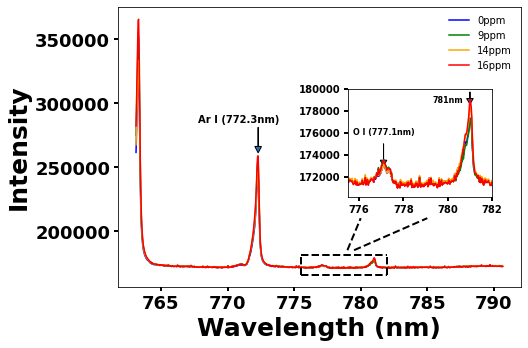

In [21]:
############################## Visualizing the Avg. Spectrum of each Concentration ##############################
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from pylab import figure, text, scatter, show

fig,ax = plt.subplots(figsize = (8,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.25,hspace = 0.5, wspace=0.5)

color_dic = {0: 'blue', 9: 'green', 14: 'orange', 16:'red'}
label_dic = {0:'0ppm',1:'9ppm',2:'14ppm',3:'16ppm'}

for i,conc in enumerate(conc_mean_dic.keys()):
  plt.plot(wavelength, conc_mean_dic[conc],  c=color_dic[conc],label = str(conc)+"ppm")

ax.legend(frameon=False)
plt.xlabel('Wavelength (nm)',fontsize=25,fontweight="bold")
plt.ylabel('Intensity',fontsize=25,fontweight="bold")

plt.tick_params(which='both', length=4, width=2, labelsize=18,colors='black')
plt.setp(ax.get_xticklabels(), fontweight="bold")
plt.setp(ax.get_yticklabels(), fontweight="bold")

plt.plot([775.5, 775.5], [166000, 181000], '--', lw=2,color='black')
plt.plot([782, 782], [166000, 181000], '--', lw=2,color='black')
plt.plot([775.5, 782], [166000, 166000], '--', lw=2,color='black')
plt.plot([775.5, 782], [181000, 181000], '--', lw=2,color='black')

plt.plot([779, 780], [185000, 210000], '--', lw=2,color='black')
plt.plot([779.5, 785], [185000, 210000], '--', lw=2,color='black')


left, bottom, width, height = [0.6, 0.46, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
for conc in conc_mean_dic.keys():
  ax2.plot(wavelength, conc_mean_dic[conc],  c=color_dic[conc],label = str(conc)+"ppm")

ax2.set_xlim(775.5,782)
ax2.set_ylim(170200,180000)
ax2.tick_params(which='both', length=4, width=2, labelsize=10,colors='black')
plt.setp(ax2.get_xticklabels(), fontweight="bold")
plt.setp(ax2.get_yticklabels(), fontweight="bold")
ax2.arrow(777.1, 175000, 0, -2000,length_includes_head=True,head_width=0.3, head_length=500)
ax2.arrow(781, 179700,0,-1100, length_includes_head=True,head_width=0.3, head_length=500)
ax.arrow(772.3, 281000, 0, -20000, length_includes_head=True,head_width=0.5, head_length=5000)
text(0.25, 0.6,'O I (777.1nm)',fontweight="bold",fontsize=8, ha='center', va='center', transform=ax2.transAxes)
text(0.69, 0.90,'781nm',fontweight="bold",fontsize=8, ha='center', va='center', transform=ax2.transAxes)
text(0.30, 0.6,'Ar I (772.3nm)',fontweight="bold",fontsize=10, ha='center', va='center', transform=ax.transAxes)
plt.show()

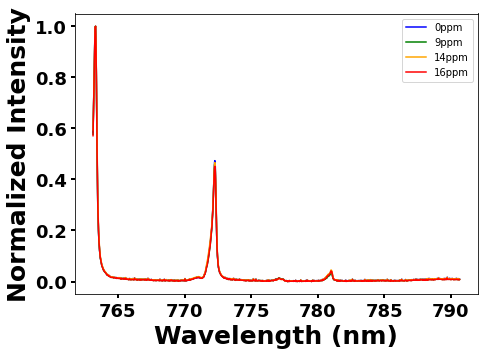

In [22]:
############################## Normalizing the Spectra Set ##############################
min_max_sclaer = MinMaxScaler()
scaled_conc_dic = {}
mean_scaled_conc_dic = {}

for conc in conc_dic.keys():
  scaled_conc_dic.update({conc:pd.DataFrame(data = min_max_sclaer.fit_transform(conc_dic[conc]))})
  mean_scaled_conc_dic.update({conc:pd.DataFrame(data = min_max_sclaer.fit_transform(conc_mean_dic[conc]))})


fig,ax = plt.subplots(figsize = (8,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.25,hspace = 0.5, wspace=0.5)


for conc in mean_scaled_conc_dic.keys():
  plt.plot(wavelength, mean_scaled_conc_dic[conc][0],  c=color_dic[conc],label = str(conc)+'ppm')

plt.legend()
plt.xlabel('Wavelength (nm)',fontsize=25,fontweight="bold")
plt.ylabel('Normalized Intensity',fontsize=25,fontweight="bold")
plt.tick_params(which='both', length=4, width=2, labelsize=18,colors='black')
plt.setp(ax.get_xticklabels(), fontweight="bold")
plt.setp(ax.get_yticklabels(), fontweight="bold")
plt.show()

In [23]:
############################## Creating Training Set: X ##############################
train_size = 232
spc_train = {}
for conc in scaled_conc_dic.keys():
  spc_train.update({conc:scaled_conc_dic[conc].T.sample(n=train_size,random_state=7)})

X = pd.concat([spc_train[conc] for conc in spc_train.keys()],axis = 0,ignore_index=True)
X_mean = pd.concat([mean_scaled_conc_dic[conc].T for conc in mean_scaled_conc_dic],axis = 0,ignore_index=True)
print('Dataset size',X.shape)
print('Dataset mean size',X_mean.shape)

############################## Creating Response Set: Y ##############################
norm_conc_list = [float(i)/max(conc_list) for i in conc_list]
dummy_arr = np.array([])
for val in norm_conc_list:
  dummy_arr = np.concatenate((dummy_arr,np.array([val]*train_size)),axis=0)

Y = pd.DataFrame(data=dummy_arr, columns = ['concentration (ppm)']) 

############################## Creating Train and Test Sets ##############################
split_test = 0.3
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=split_test,random_state = 1)
X_train.shape

Dataset size (928, 1024)
Dataset mean size (4, 1024)


(649, 1024)

### Linear Regression for Oxygen Detection:
In classical analytical chemistry, the peak of signiture wavelength of an analyte is being used to establish a relationship between the concentration of analyte and its signiture wavelength. In this case, from National Institute of Standards and Technology (NIST) tables, we know Oxygen has unique peak at 777.19 nm. Let's attempt to use the classical method to establish a regression based on 777.19 nm wavelength:

In [32]:
x = np.where((wavelength["wavelength (nm)"].values<777.3) & (wavelength["wavelength (nm)"].values>777.1))
print("The index for 777.19 is ~",518)
wavelength.iloc[x]

The index for 777.19 is ~ 518


,wavelength (nm)
515,777.113
516,777.140
517,777.166
518,777.193
519,777.220
520,777.247
521,777.274


R2 for classical approach is= 0.0071711233231486204


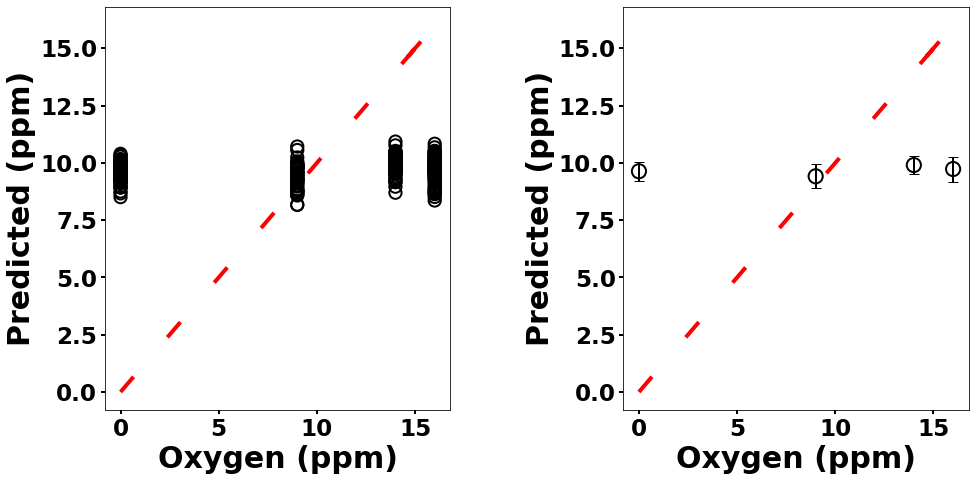

In [62]:
X_train_lr = X_train[518].values
reg = LinearRegression().fit(X_train_lr.reshape(-1,1), Y_train["concentration (ppm)"].values)
print("R2 for classical approach is=",reg.score(X_train_lr.reshape(-1,1), Y_train["concentration (ppm)"].values))
Y_pred_lr = max_concentration*reg.predict(X_test[518].values.reshape(-1,1))
lr_result_dic = {}
for val in conc_list:
  lr_result_dic.update({val:np.array([])})

max_concentration = conc_list[-1]
for i,val in enumerate(Y_test['concentration (ppm)']):
  lr_result_dic[val*max_concentration] = np.append(lr_result_dic[val*max_concentration],Y_pred_lr[i])

fig, axes = plt.subplots(1, 2,figsize=(16,8))
fig.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.5, wspace=0.5)

axes = axes.ravel()

axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[0].scatter(Y_test*max_concentration, Y_pred_lr, s=150,linewidth=2,
            facecolors='none', edgecolors='black')

axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')

plt.setp(axes[0].get_xticklabels(), fontweight="bold")
plt.setp(axes[0].get_yticklabels(), fontweight="bold")


axes[1].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[1].scatter(conc_list, [lr_result_dic[val].mean() for val in lr_result_dic.keys()], s=200,linewidth=2,
                facecolors='none', edgecolors='black')

axes[1].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[1].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[1].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes[1].errorbar(conc_list, [lr_result_dic[val].mean() for val in lr_result_dic.keys()],
                                              yerr=[lr_result_dic[val].std() for val in lr_result_dic.keys()],fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes[1].get_xticklabels(), fontweight="bold")
plt.setp(axes[1].get_yticklabels(), fontweight="bold")

plt.show()

Clearly, classical univariate regression cannot establish any relationship between Oxygen concentration and Oxygen peak. Here, we only have used 1 feature out of 1024 features available in the spectrum. Hence, in the next steps we will use multivariate models such as LASSO and CNN to establish any relationship between Oxygen concentrations and corresponding spectrum.

### Convolutional Neural Network:

In [7]:
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D,MaxPooling1D, Input
from keras.utils import plot_model
from keras import optimizers
from keras.optimizers import SGD,Adam
import random

model = tf.keras.Sequential()

#Architecture #1:
model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
#model.add(tf.keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model.add(tf.keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='relu'))


opt = tf.keras.optimizers.Adam(lr=0.0001)
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)
model.compile(loss='mse', optimizer=opt,metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 5)           20        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 340, 5)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 338, 3)            48        
_________________________________________________________________
dropout (Dropout)            (None, 338, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 336, 3)            30        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 112, 3)            0         
_________________________________________________________________
flatten (Flatten)            (None, 336)               0

In [ ]:
############################## Training the CNN Model ##############################
input_X_train = X_train.values.reshape(-1,X_train.shape[1],1)
input_Y_train = Y_train.values.reshape(Y_train.shape[0],1)
print('X_input shape = ',input_X_train.shape)
print('Y_input shape = ',input_Y_train.shape)
history = model.fit(input_X_train, input_Y_train, epochs=4000, verbose=1,batch_size = 50, validation_split = 0.2,shuffle=False,
                    callbacks=[tensorboard])

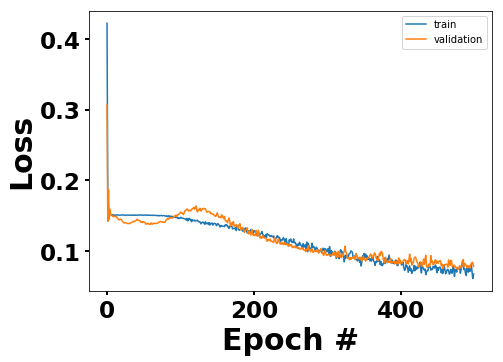

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.25,hspace = 0.5, wspace=0.5)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.xlabel('Epoch #',fontsize=30,weight='bold')
plt.ylabel('Loss',fontsize=30,weight='bold')
#plt.title('Model Loss',fontsize=35)
plt.setp(axes.get_xticklabels(), fontweight="bold")
plt.setp(axes.get_yticklabels(), fontweight="bold")
axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
PATH = '/content/drive/My Drive/Data/Graphs/'
plt.savefig(PATH+"Epoch.png",format='png', dpi=1200)

In [ ]:
############################## Saving the Trained Model ##############################
from keras.models import model_from_json
from keras.models import load_model

#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("CNN_SunEdison_0004.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("CNN_SunEdison_0004.h5")

## Loading the saved model:

In [8]:
PATH = '/content/drive/My Drive/Data/Model and Weights/'
json_file = open(PATH+'CNN_SunEdison_0004.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
cnn_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
cnn_model.load_weights(PATH+"CNN_SunEdison_0004.h5")
print("Loaded model from disk")

cnn_model.save(PATH+'CNN_SunEdison_0004.hdf5')
cnn_model=tf.keras.models.load_model(PATH+'CNN_SunEdison_0004.hdf5')
cnn_model.compile(loss='mse', optimizer=opt,metrics=['mse'])


Loaded model from disk


In [9]:
input_X_test = X_test.values.reshape(-1,X_test.shape[1],1)
Y_pred = cnn_model.predict(input_X_test, verbose=0)
cnn_model.evaluate(input_X_test,Y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.0371 - mse: 0.0371


[0.03448044881224632, 0.03448044881224632]

In [10]:
test_result_dic = {}
for val in conc_list:
  test_result_dic.update({val:np.array([])})

max_concentration = conc_list[-1]
for i,val in enumerate(Y_test['concentration (ppm)']):
  test_result_dic[val*max_concentration] = np.append(test_result_dic[val*max_concentration],max_concentration*Y_pred[i][0])

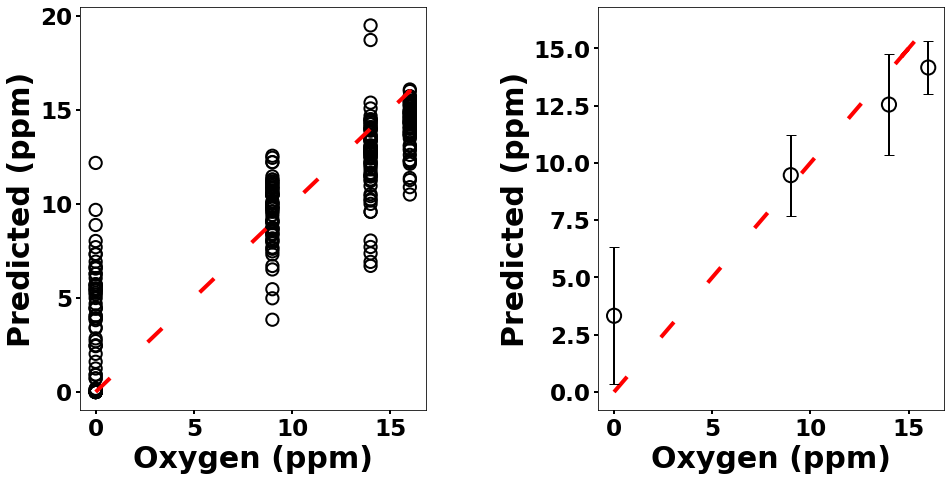

In [11]:
fig, axes = plt.subplots(1, 2,figsize=(16,8))
fig.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.5, wspace=0.5)

axes = axes.ravel()

axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[0].scatter(Y_test*max_concentration, Y_pred*max_concentration, s=150,linewidth=2,
            facecolors='none', edgecolors='black')

axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')

plt.setp(axes[0].get_xticklabels(), fontweight="bold")
plt.setp(axes[0].get_yticklabels(), fontweight="bold")


axes[1].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[1].scatter(conc_list, [test_result_dic[val].mean() for val in test_result_dic.keys()], s=200,linewidth=2,
                facecolors='none', edgecolors='black')

axes[1].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[1].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[1].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes[1].errorbar(conc_list, [test_result_dic[val].mean() for val in test_result_dic.keys()],
                                              yerr=[test_result_dic[val].std() for val in test_result_dic.keys()],fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes[1].get_xticklabels(), fontweight="bold")
plt.setp(axes[1].get_yticklabels(), fontweight="bold")

plt.show()

### **Predicting Unseen Samples**

In [12]:
############################## Unseen Sample ##############################
conc_11_scaled = pd.DataFrame(data = min_max_sclaer.fit_transform(conc_11))
print('11 ppm scaled shape', conc_11_scaled.shape)
X_test_11ppm = conc_11_scaled.T
input_X_test_11ppm = X_test_11ppm.values.reshape(-1,X_test_11ppm.shape[1],1)
Y_pred_loaded_11ppm = cnn_model.predict(input_X_test_11ppm, verbose=0)

11 ppm scaled shape (1024, 280)


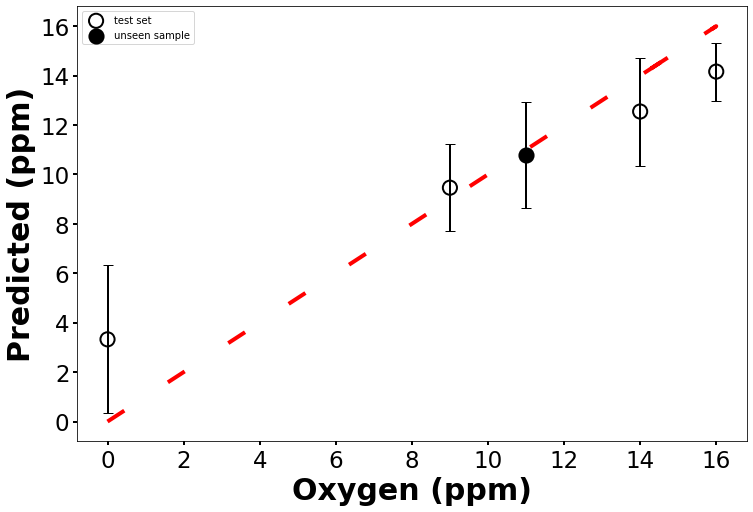

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
ax.scatter(conc_list, [test_result_dic[val].mean() for val in test_result_dic.keys()], s=200,linewidth=2,
                facecolors='none', edgecolors='black',label="test set")

ax.set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
ax.set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
ax.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = ax.errorbar(conc_list, [test_result_dic[val].mean() for val in test_result_dic.keys()],
                                              yerr=[test_result_dic[val].std() for val in test_result_dic.keys()],fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

ax.scatter(11,max_concentration*Y_pred_loaded_11ppm.reshape(-1,Y_pred_loaded_11ppm.size)[0].mean(), s=200,linewidth=2,
                facecolors='black', edgecolors='black',label="unseen sample")
plotline, cap, barlinecols = ax.errorbar(11,max_concentration*Y_pred_loaded_11ppm.reshape(-1,Y_pred_loaded_11ppm.size)[0].mean(),
                                              yerr=max_concentration*Y_pred_loaded_11ppm.reshape(-1,Y_pred_loaded_11ppm.size)[0].std()
                                         ,fmt='o', color='none',ecolor='black', elinewidth=2,capsize=5)
plt.legend()
plt.show()

### LASSO:

Min MSE Test index= 10
alpha_minimize_Test= 8.177257525083613e-06


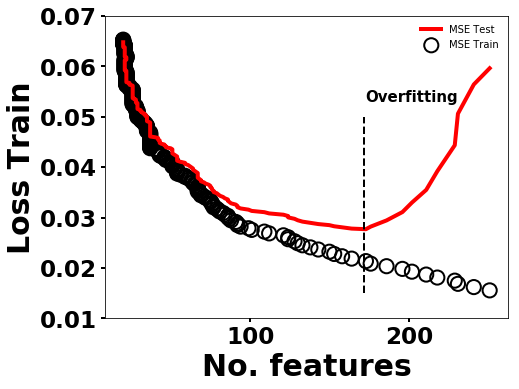

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error


min_c = 0.000005
max_c = 0.0001
division_c = 300
max_iter = 50000

# alpha_list = np.linspace(min_c,max_c,division_c)
# MSE_train = []
# MSE_test = []
# No_components = []
# for c in alpha_list:
#     result = []
#     Lasso_reg = linear_model.Lasso(c,max_iter)
#     Lasso_reg.fit(X_train, Y_train)
#     MSE_train.append(mean_squared_error(Lasso_reg.predict(X_train), Y_train)+c*sum(abs(Lasso_reg.coef_.T)))
#     y_pred_Lasso_reg=Lasso_reg.predict(X_test)
#     MSE_test.append(mean_squared_error(y_pred_Lasso_reg, Y_test)+c*sum(abs(Lasso_reg.coef_.T)))
#     No_components.append(np.count_nonzero(Lasso_reg.coef_.T))


fig, axes = plt.subplots(figsize=(8,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.2,hspace = 0.6, wspace=0.6)
#axes = axes.ravel()

# axes[0].scatter(No_components,MSE_train, s=100,linewidth=2,facecolors='none', edgecolors='black')
# #axes[0].set_xlim(0,100)
# axes[0].set_ylim(0.01,0.07)
# axes[0].set_xlabel('No. features',fontsize=25,weight='bold')
# axes[0].set_ylabel('Loss Train',fontsize=25,weight='bold')
# axes[0].tick_params(which='both', length=4, width=2, labelsize=15,colors='black')
# plt.setp(axes[0].get_xticklabels(), fontweight="bold")
# plt.setp(axes[0].get_yticklabels(), fontweight="bold")

axes.scatter(No_components,MSE_train, s=200,linewidth=2,facecolors='none', edgecolors='black',label='MSE Train')
axes.plot(No_components,MSE_test, color='red',linewidth=4,label='MSE Test')
#axes[0].set_xlim(0,100)
axes.set_ylim(0.01,0.07)
axes.set_xlabel('No. features',fontsize=30,weight='bold')
axes.set_ylabel('Loss Train',fontsize=30,weight='bold')
axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plt.setp(axes.get_xticklabels(), fontweight="bold")
plt.setp(axes.get_yticklabels(), fontweight="bold")
axes.legend(frameon=False)
plt.plot([172, 172], [0.015, 0.05], '--', lw=2,color='black')
text(0.76, 0.73,'Overfitting',fontweight="bold",fontsize=15, ha='center', va='center', transform=axes.transAxes)


# axes[1].scatter(No_components, MSE_test, s=100,linewidth=2,facecolors='none', edgecolors='black')
# # axes[1].set_xlim(0,100)
# axes[1].set_ylim(0.02,0.07)
# axes[1].set_xlabel('No. features',fontsize=25,weight='bold')
# axes[1].set_ylabel('Loss Test',fontsize=25,weight='bold')
# axes[1].tick_params(which='both', length=4, width=2, labelsize=15,colors='black')
# plt.setp(axes[1].get_xticklabels(), fontweight="bold")
# plt.setp(axes[1].get_yticklabels(), fontweight="bold")

# axes.scatter(No_components, MSE_test, s=200,linewidth=2,facecolors='none', edgecolors='black')
# # axes[1].set_xlim(0,100)
# axes.set_ylim(0.02,0.07)
# axes.set_xlabel('No. features',fontsize=30,weight='bold')
# axes.set_ylabel('Loss Test',fontsize=30,weight='bold')
# axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
# plt.setp(axes.get_xticklabels(), fontweight="bold")
# plt.setp(axes.get_yticklabels(), fontweight="bold")


# axes[2].scatter(No_components, alpha_list, s=100,linewidth=2,facecolors='none', edgecolors='black')
# # axes[2].set_xlim(0,25)
# # axes[2].set_ylim(0,0.005)
# axes[2].set_xlabel('No. features',fontsize=20,weight='bold')
# axes[2].set_ylabel('alpha',fontsize=20,weight='bold')
# axes[2].tick_params(which='both', length=4, width=2, labelsize=15,colors='black')
# plt.setp(axes[2].get_xticklabels(), fontweight="bold")
# plt.setp(axes[2].get_yticklabels(), fontweight="bold")


# axes[3].scatter(No_components, MSE_test, s=100,linewidth=2,facecolors='none', edgecolors='black')
# # axes[3].set_xlim(5,30)
# # axes[3].set_ylim(0.03,0.08)
# axes[3].set_xlabel('No. features',fontsize=20,weight='bold')
# axes[3].set_ylabel('MSE Test(zommed)',fontsize=20,weight='bold')
# axes[3].tick_params(which='both', length=4, width=2, labelsize=15,colors='black')
# plt.setp(axes[3].get_xticklabels(), fontweight="bold")
# plt.setp(axes[3].get_yticklabels(), fontweight="bold")

print('Min MSE Test index=',np.argmin(MSE_test))
print('alpha_minimize_Test=',alpha_list[np.argmin(MSE_test)])

PATH = '/content/drive/My Drive/Data/Graphs/Final/LASSO/'
plt.savefig(PATH+"LASSO_Optimization_Train_2.png",format='png', dpi=1200)

### Visualizing filters:

We are trying to understand how CNN is capable of establishing correlation between the oxygen concentration and 

In [16]:
layer_outputs = [layer.output for layer in cnn_model.layers]
activation_model = tf.keras.models.Model(inputs=cnn_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(input_X_test) ## activation[layer_No][No_sample][pixels][filter_No]

In [17]:
activation_11ppm = activation_model.predict(input_X_test_11ppm) ## activation[layer_No][No_sample][pixels][filter_No]

In [18]:
Y_test_vis = Y_test.copy()
Y_test_vis = Y_test_vis.reset_index(drop=True)

In [ ]:
index_dic = {}
for val in concentration:
  index_dummy = []
  index_dummy = Y_test_vis.groupby(['O (ppm)']).get_group(val).index.tolist()
  index_dic.update({val:index_dummy})

In [ ]:
distribution_dic = {}  ## dictionary = {concentration:{layer:{filter: A list containing convoluted all test spectra set}}}
filter_vis = {} ## dictionary = {concentration:{layer:{filter:avg}}}
tot_layer = 6
for conc in concentration:
  dummy_dic_1 = {}
  dummy_dic_4 = {}
  for layer_No in range(0,tot_layer):
    dummy_dic_2 = {}
    dummy_dic_3 = {}
    for f_val in range(0,activations[layer_No][0, :].shape[1]):
      dummy_list_1 = []
      for index_val in index_dic[conc]:
        dummy_list_1.append(activations[layer_No][index_val, :,f_val].tolist())
      dummy_dic_2.update({f_val:[float(sum(col))/len(col) for col in zip(*dummy_list_1)]})
      dummy_dic_3.update({f_val:dummy_list_1})
    dummy_dic_1.update({layer_No:dummy_dic_2})
    dummy_dic_4.update({layer_No:dummy_dic_3})
  filter_vis.update({conc:dummy_dic_1})
  distribution_dic.update({conc:dummy_dic_4})

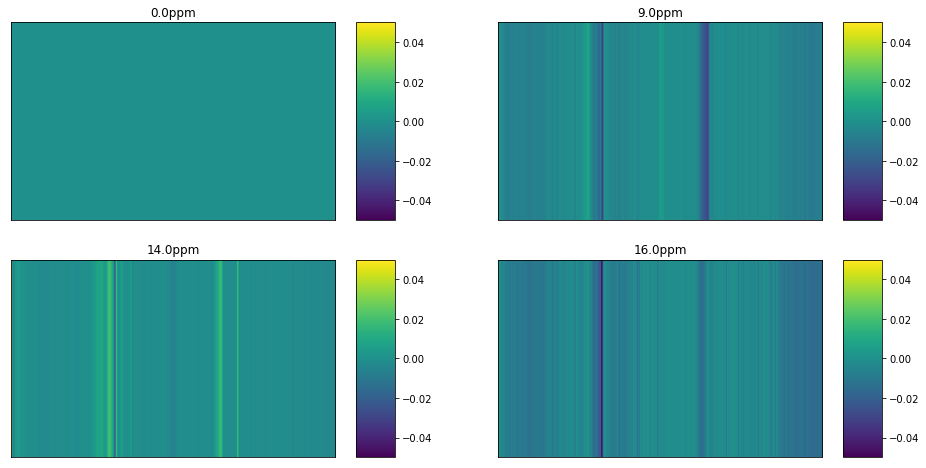

In [ ]:
layer_No = 4
filter_No = 1
fig,ax = plt.subplots(2,2,figsize = (16,8))
ax = ax.ravel()

for i in range (0,len(concentration)):
  # input_map = filter_vis[concentration[i]][layer_No][filter_No]
  input_map = [(a_i - b_i) for a_i, b_i in zip(filter_vis[concentration[i]][layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
  input_map = np.expand_dims(input_map, axis=0)
  pos = ax[i].imshow(input_map,cmap='viridis',aspect="auto",vmin=-0.05, vmax=0.05)
  ax[i].set_title(str(concentration[i]*max_concentration)+'ppm')
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  fig.colorbar(pos,aspect=5,ax=ax[i])

plt.show()

In [ ]:
dic_11ppm_filter_vis = {}  ## dictionary = {layer_No:{filter_No:avg}}


for layer in range(0,tot_layer):
  dummy_dic_11ppm = {}
  for f_val in range(0,activation_11ppm[layer_No][0, :].shape[1]):
    dummy_list_11ppm = []
    for i in range(0,activation_11ppm[0].shape[0]):
      dummy_list_11ppm.append(activation_11ppm[layer][i, :,f_val].tolist())
    dummy_dic_11ppm.update({f_val:[float(sum(col))/len(col) for col in zip(*dummy_list_11ppm)]})
  dic_11ppm_filter_vis.update({layer:dummy_dic_11ppm})

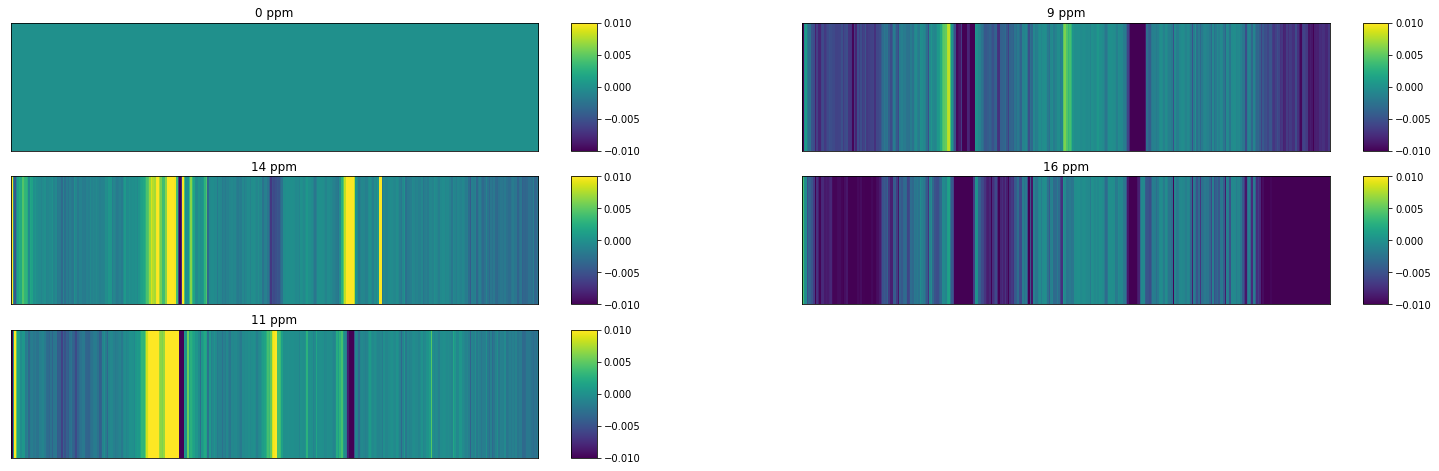

In [ ]:
layer_No = 4
filter_No = 1
vmin_map = -0.01
vmax_map = 0.01

fig,ax = plt.subplots(3,2,figsize = (26,8))
ax = ax.ravel()

for i in range (0,len(concentration)):
  # input_map = [(a_i - b_i)/((b_i+1)) for a_i, b_i in zip(filter_vis[concentration[i]][layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
  # input_map = [abs((a_i - b_i)/((b_i+1))) for a_i, b_i in zip(filter_vis[concentration[i]][layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
  input_map = [(a_i - b_i) for a_i, b_i in zip(filter_vis[concentration[i]][layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
  # input_map = [abs((a_i - b_i)) for a_i, b_i in zip(filter_vis[concentration[i]][layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
  # input_map = filter_vis[concentration[i]][layer_No][filter_No]
  input_map = np.expand_dims(input_map, axis=0)
  pos = ax[i].imshow(input_map,cmap='viridis',aspect="auto",vmin=vmin_map, vmax=vmax_map)
  ax[i].set_title(str(int(concentration[i]*max_concentration))+' ppm')
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  fig.colorbar(pos,aspect=5,ax=ax[i])

# input_map_11ppm =  [(a_i - b_i)/(b_i+1) for a_i, b_i in zip(dic_11ppm_filter_vis[layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
# input_map_11ppm =  [abs((a_i - b_i)/(b_i+1)) for a_i, b_i in zip(dic_11ppm_filter_vis[layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
input_map_11ppm =  [(a_i - b_i) for a_i, b_i in zip(dic_11ppm_filter_vis[layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
# input_map_11ppm =  [abs((a_i - b_i)) for a_i, b_i in zip(dic_11ppm_filter_vis[layer_No][filter_No], filter_vis[concentration[0]][layer_No][filter_No])]
# input_map_11ppm = dic_11ppm_filter_vis[layer_No][filter_No]
input_map_11ppm = np.expand_dims(input_map_11ppm, axis=0)
pos = ax[4].imshow(input_map_11ppm,cmap='viridis',aspect="auto",vmin=vmin_map, vmax=vmax_map)
ax[4].set_title('11 ppm')
ax[4].set_xticks([])
ax[4].set_yticks([])
fig.colorbar(pos,aspect=5,ax=ax[4])
fig.delaxes(ax.flat[-1])
plt.show()

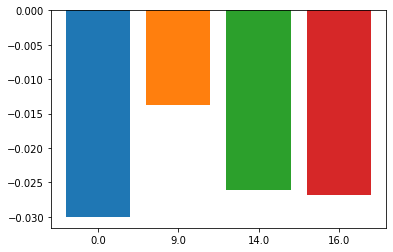

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# cosine_similarity(input_map, input_map_11ppm)[0][0]


for i in range (0,len(concentration)):
  input_map = filter_vis[concentration[i]][layer_No][filter_No]
  input_map = np.expand_dims(input_map, axis=0)
  plt.bar(str(concentration[i]*max_concentration),cosine_similarity(input_map, input_map_11ppm)[0][0])

In [ ]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1022, 5)           20        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 340, 5)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 338, 3)            48        
_________________________________________________________________
dropout_4 (Dropout)          (None, 338, 3)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 336, 3)            30        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 112, 3)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 336)              

# **Visualizing the layer in lower dimensions**:

The original input is in
\begin{align}
\vec{\mathbf{I}}&\in\mathbb{R^{1024}}
\end{align}

As the input flows through CNN filters, its dimension reduces:
\begin{align}
\vec{\mathbf{I_n}}&\in\mathbb{R^{n}}
\end{align}
where 
\begin{align}
n<1024
\end{align}
<br>
By plotting the heatmap, we can visualize the filters output. For sure, we can observe that the outputs are different for various concentrations. However, it is still difficult to detect systematic changes in the filters output. The systematic changes will assist us to understand how the CNN models looks at the spectra set and learn to predict. Moreover, it helps to detect the features that are seen by the CNN and used for prediction. Therefore, here we attempt to employ dimension reduction techniques such as PCA and autoencoder to map the filters outputs into lower dimensions (3D) for better understanding of how the network works.

## **PCA** ##

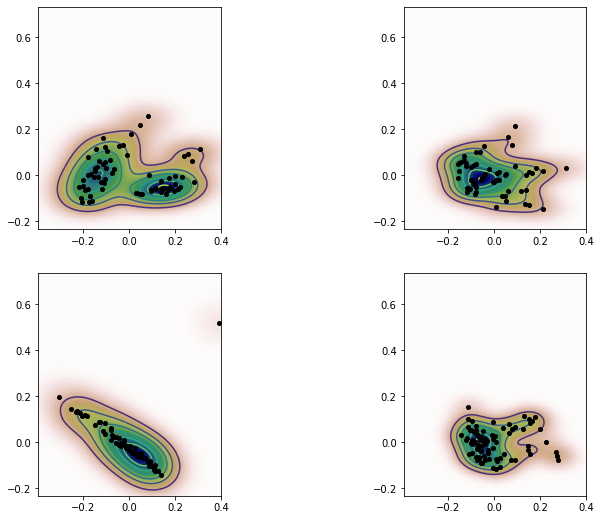

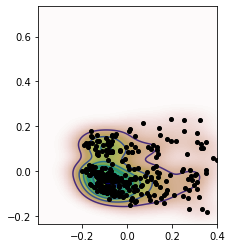

In [ ]:
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit


k_1 = 0
k_2 = 1
alpha_x = 0.3
alpha_y = 0.3

xmin = 0
xmax = 0
ymin = 0
ymax = 0

n_pca = 10
pca = PCA(n_components=n_pca)


for i in range(0,len(concentration)):
  X_o = np.array(distribution_dic[concentration[i]][layer_No][filter_No])
  X_r = pca.fit(X_o).transform(X_o)
  if xmin>X_r[:,k_1].min():
    xmin = X_r[:,k_1].min()
  if xmax<X_r[:,k_1].max():
    xmax = X_r[:,k_1].max()
  if ymin>X_r[:,k_2].min():
    ymin = X_r[:,k_2].min()
  if ymax<X_r[:,k_2].max():
    ymax = X_r[:,k_2].max()

X_o_11ppm = np.array(activation_11ppm[layer_No][:,:,filter_No])
X_r_11ppm = pca.fit(X_o_11ppm).transform(X_o_11ppm)

if xmin>X_r_11ppm[:,k_1].min():
  xmin = X_r_11ppm[:,k_1].min()
if xmax<X_r_11ppm[:,k_1].max():
  xmax = X_r_11ppm[:,k_1].max()
if ymin>X_r_11ppm[:,k_2].min():
  ymin = X_r_11ppm[:,k_2].min()
if ymax<X_r_11ppm[:,k_2].max():
  ymax = X_r_11ppm[:,k_2].max()

xmin = xmin-abs(xmin*alpha_x)
xmax = xmax+abs(xmax*alpha_x)
ymin = ymin-abs(ymin*alpha_y)
ymax = ymax+abs(ymax*alpha_y)

def density_estimation(m1, m2):
    # xmin = m1.min()-abs(m1.min()*alpha)
    # xmax = m1.max()+abs(m1.max()*alpha)
    # ymin = m2.min()-abs(m2.min()*alpha)
    # ymax = m2.max()+abs(m2.max()*alpha)
    X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

fig, ax = plt.subplots(2,2,figsize = (12,9))  
xmax = 0.4
ax = ax.ravel()
for i in range(0,len(concentration)):
  X_o = np.array(distribution_dic[concentration[i]][layer_No][filter_No])
  X_r = pca.fit(X_o).transform(X_o)
  X, Y, Z = density_estimation(X_r[:,k_1], X_r[:,k_2])
  ax[i].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin,xmax,ymin,ymax])
  ax[i].contour(X, Y, Z,extent=[xmin,xmax,ymin,ymax])                                                                           
  ax[i].plot(X_r[:,k_1], X_r[:,k_2], 'k.', markersize=8)    
  ax[i].set_xlim([xmin,xmax])                                                                           
  ax[i].set_ylim([ymin,ymax])                                                           

fig1, ax1 = plt.subplots(figsize = (6,4))  
X_o_11ppm = np.array(activation_11ppm[layer_No][:,:,filter_No])
X_r_11ppm = pca.fit(X_o_11ppm).transform(X_o_11ppm)
X, Y, Z = density_estimation(X_r_11ppm[:,k_1], X_r_11ppm[:,k_2])
ax1.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin,xmax,ymin,ymax])
ax1.contour(X, Y, Z,extent=[xmin,xmax,ymin,ymax])                                                                           
ax1.plot(X_r_11ppm[:,k_1], X_r_11ppm[:,k_2], 'k.', markersize=8)    
ax1.set_xlim([xmin,xmax])                                                                           
ax1.set_ylim([ymin,ymax])  
plt.show()                                                            


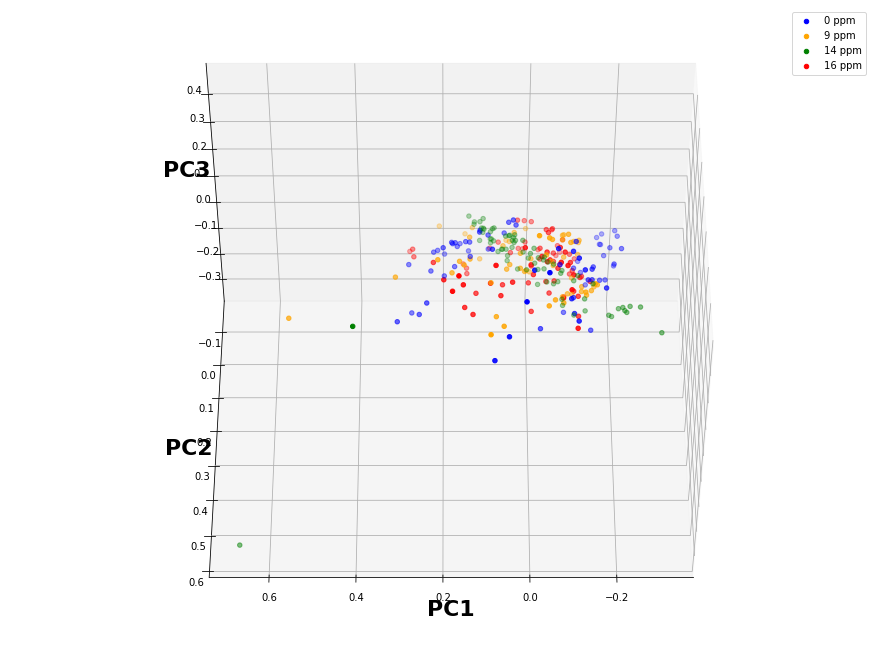

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
k_1 = 0
k_2 = 1
k_3 = 2
fig, ax = plt.subplots(figsize = (12,9))  
ax = Axes3D(fig)
ax.view_init(50, 90) ## (z angle,xy plane angle): r,theta cordinate system
xmax = 0.4
X_o_0 = np.array(distribution_dic[concentration[0]][layer_No][filter_No])
X_r_0 = pca.fit(X_o_0).transform(X_o_0)
sp1 = ax.scatter(X_r_0[:,k_1], X_r_0[:,k_2],X_r_0[:,k_3],label='0 ppm',c='b') 

X_o_9 = np.array(distribution_dic[concentration[1]][layer_No][filter_No])
X_r_9 = pca.fit(X_o_9).transform(X_o_9)
sp2 = ax.scatter(X_r_9[:,k_1], X_r_9[:,k_2],X_r_9[:,k_3],label='9 ppm',c='orange') 

X_o_14 = np.array(distribution_dic[concentration[2]][layer_No][filter_No])
X_r_14 = pca.fit(X_o_14).transform(X_o_14)
sp3 = ax.scatter(X_r_14[:,k_1], X_r_14[:,k_2],X_r_14[:,k_3],label='14 ppm',c='green') 

X_o_16 = np.array(distribution_dic[concentration[3]][layer_No][filter_No])
X_r_16 = pca.fit(X_o_16).transform(X_o_16)
sp4 = ax.scatter(X_r_16[:,k_1], X_r_16[:,k_2],X_r_16[:,k_3],label='16 ppm',c='r')

ax.set_xlabel('PC1',size=22,weight = 'bold')
ax.set_ylabel('PC2',size=22,weight = 'bold')
ax.set_zlabel('PC3',size=22,weight = 'bold') 
plt.legend(handles=[sp1, sp2,sp3,sp4])
plt.show()

[0.5841553440742956, 0.798085883996844, 0.8704896689736008, 0.9099328462366958, 0.932554116754792, 0.9423385752318733, 0.9500292936557517, 0.9543341892093999, 0.9578638313331599, 0.9608732961603329]


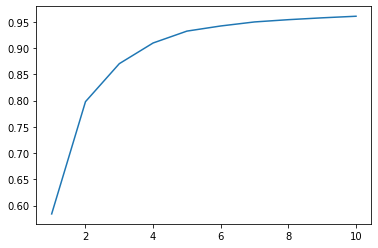

In [ ]:
cum_explained_variance = []
r1 = 0
for val in pca.explained_variance_ratio_:
  r1 += val
  cum_explained_variance.append(r1)

print(cum_explained_variance)
plt.plot([i for i in range (1,len(pca.explained_variance_ratio_)+1)], cum_explained_variance)
plt.show()

In [ ]:
autoencoder_train = np.array(distribution_dic[concentration[0]][layer_No][filter_No])
for i in range(1,len(concentration)):
  X_o = np.array(distribution_dic[concentration[i]][layer_No][filter_No])
  autoencoder_train = np.vstack((autoencoder_train,X_o))

autoencoder_train_11ppm = np.array(activation_11ppm[layer_No][:,:,filter_No])  

## **Autoencoder**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

encoder_dim_1 = 128
encoder_dim_2 = 32
encoder_dim_3 = 4

autoencoder = Sequential()
autoencoder.add(Dense(encoder_dim_1,  activation='elu', input_shape=(336,)))
autoencoder.add(Dense(encoder_dim_2,  activation='elu'))
autoencoder.add(Dense(encoder_dim_3,  activation='linear', name="bottleneck"))
autoencoder.add(Dense(encoder_dim_2,  activation='elu'))
autoencoder.add(Dense(encoder_dim_1,  activation='elu'))
autoencoder.add(Dense(336, activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=opt,metrics=['mse'])

autoencoder.summary()

NameError: ignored

In [ ]:
trained_model = autoencoder.fit(autoencoder_train, autoencoder_train, batch_size=32, epochs=1000, verbose=1,validation_split = 0.2,callbacks=[es])

Train on 223 samples, validate on 56 samples
Epoch 1/1000
223/223 [==============================] - 1s 3ms/step - loss: 0.2166 - val_loss: 0.1925
Epoch 2/1000
223/223 [==============================] - 0s 194us/step - loss: 0.1462 - val_loss: 0.0895
Epoch 3/1000
223/223 [==============================] - 0s 180us/step - loss: 0.0452 - val_loss: 0.0126
Epoch 4/1000
223/223 [==============================] - 0s 198us/step - loss: 0.0048 - val_loss: 0.0014
Epoch 5/1000
223/223 [==============================] - 0s 194us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/1000
223/223 [==============================] - 0s 182us/step - loss: 0.0013 - val_loss: 9.9502e-04
Epoch 7/1000
223/223 [==============================] - 0s 180us/step - loss: 0.0012 - val_loss: 9.5431e-04
Epoch 8/1000
223/223 [==============================] - 0s 191us/step - loss: 0.0012 - val_loss: 8.6113e-04
Epoch 9/1000
223/223 [==============================] - 0s 191us/step - loss: 0.0011 - val_loss: 8.0384e-04
Epoch

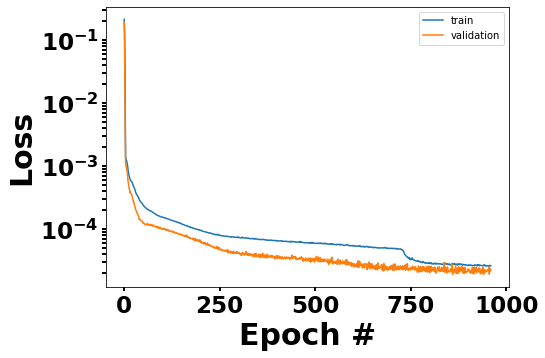

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.25,hspace = 0.5, wspace=0.5)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.xlabel('Epoch #',fontsize=30,weight='bold')
plt.ylabel('Loss',fontsize=30,weight='bold')
#plt.title('Model Loss',fontsize=35)
plt.setp(axes.get_xticklabels(), fontweight="bold")
plt.setp(axes.get_yticklabels(), fontweight="bold")
axes.set_yscale('log')
axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
# PATH = '/content/drive/My Drive/Data/Graphs/'
# plt.savefig(PATH+"Epoch.png",format='png', dpi=1200)

In [ ]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
input_X_test = X_train.values.reshape(-1,X_test.shape[1],1)
autoencoder_activations = activation_model.predict(input_X_test) ## activation[layer_No][No_sample][pixels][filter_No]

(279, 336)

In [ ]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(autoencoder_train)
decoded_output = autoencoder.predict(autoencoder_train)

encoded_data_11ppm = encoder.predict(autoencoder_train_11ppm)

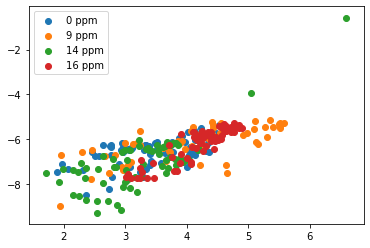

In [ ]:
g1 = plt.scatter(encoded_data[0:69,0],encoded_data[0:69,1],label='0 ppm')
g2 = plt.scatter(encoded_data[70:130,0],encoded_data[70:130,1],label='9 ppm')
g3 = plt.scatter(encoded_data[131:202,0],encoded_data[131:202,1],label='14 ppm')
g4 = plt.scatter(encoded_data[203:278,0],encoded_data[203:278,1],label='16 ppm')
plt.legend(handles=[g1, g2,g3,g4])
plt.show()

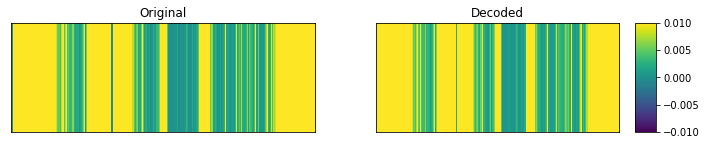

In [ ]:
# fig,ax = plt.subplots(figsize = (10,4))
# pos = ax.imshow((np.matrix(autoencoder_train[0:69,:])-np.matrix(decoded_output[0:69,:])).mean(0),cmap='viridis',aspect="auto",vmin=vmin_map, vmax=vmax_map)
# ax.set_title('Difference')
# ax.set_xticks([])
# ax.set_yticks([])
# fig.colorbar(pos,aspect=5,ax=ax)

fig,ax = plt.subplots(1,2,figsize = (12,2))
ax = ax.ravel()

pos = ax[0].imshow(np.matrix(autoencoder_train[0:69,:]).mean(0),cmap='viridis',aspect="auto",vmin=vmin_map, vmax=vmax_map)
ax[0].set_title('Original')
ax[0].set_xticks([])
ax[0].set_yticks([])

pos = ax[1].imshow(np.matrix(decoded_output[0:69,:]).mean(0),cmap='viridis',aspect="auto",vmin=vmin_map, vmax=vmax_map)
ax[1].set_title('Decoded')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(pos,aspect=5,ax=ax[1])


# # fig.delaxes(ax.flat[-1])
plt.show()

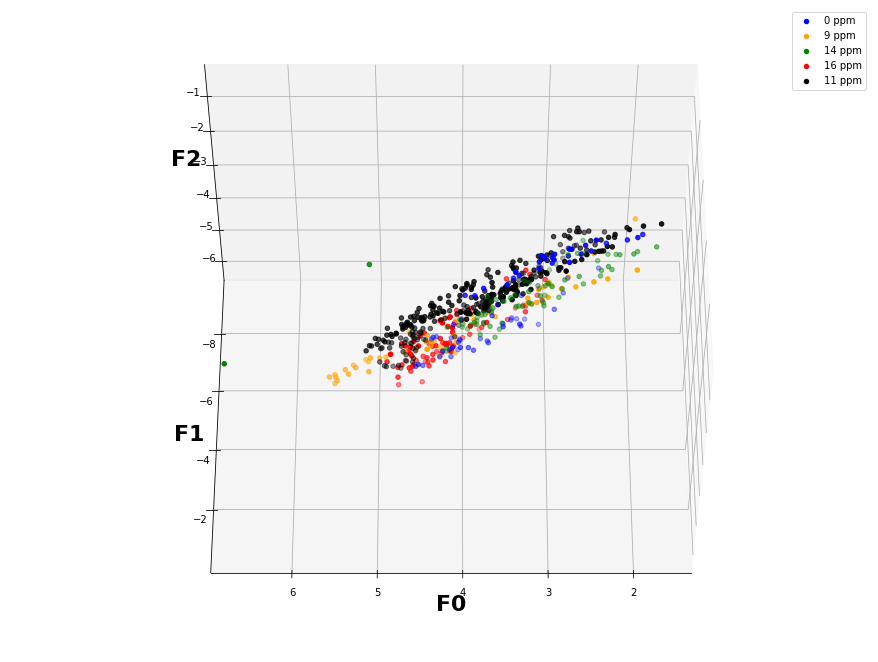

In [ ]:
k_1 = 0
k_2 = 1
k_3 = 2
fig, ax = plt.subplots(figsize = (12,9))  
ax = Axes3D(fig)
ax.view_init(55, 90) ## (z angle,xy plane angle): r,theta cordinate system
# xmax = 0.4

sp1 = ax.scatter(encoded_data[0:69,k_1], encoded_data[0:69,k_2],encoded_data[0:69,k_3],label='0 ppm',c='b') 
sp2 = ax.scatter(encoded_data[70:130,k_1], encoded_data[70:130,k_2],encoded_data[70:130,k_3],label='9 ppm',c='orange') 
sp3 = ax.scatter(encoded_data[131:202,k_1], encoded_data[131:202,k_2],encoded_data[131:202,k_3],label='14 ppm',c='green') 
sp4 = ax.scatter(encoded_data[203:278,k_1], encoded_data[203:278,k_2],encoded_data[203:278,k_3],label='16 ppm',c='r')
sp5 = ax.scatter(encoded_data_11ppm[:,k_1], encoded_data_11ppm[:,k_2],encoded_data_11ppm[:,k_3],label='11 ppm',c='black')
plt.legend(handles=[sp1, sp2,sp3,sp4,sp5])
ax.set_xlabel('F'+str(k_1),size=22,weight = 'bold')
ax.set_ylabel('F'+str(k_2),size=22,weight = 'bold')
ax.set_zlabel('F'+str(k_3),size=22,weight ='bold')
plt.show()

In [ ]:
encoded_feature_dic = {0:encoded_data[0:69,:],1:encoded_data[70:130,:],2:encoded_data[131:202,:],3:encoded_data[203:278,:]}

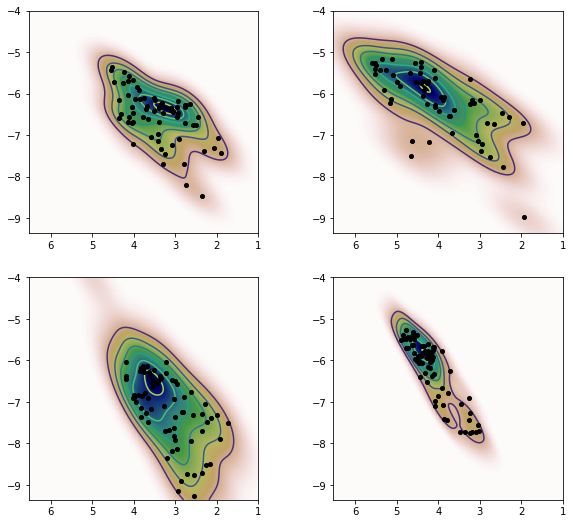

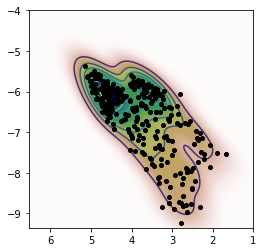

In [ ]:
k_1 = 0
k_2 = 1
alpha_x = 0.01
alpha_y = 0.01

xmin = 0
xmax = 0
ymin = 0
ymax = 0

xmin = encoded_data[:,k_1].min()
xmin = encoded_data[:,k_1].max()
ymin = encoded_data[:,k_2].min()
ymax = encoded_data[:,k_2].max()

# X_o_11ppm = np.array(activation_11ppm[layer_No][:,:,filter_No])
# X_r_11ppm = pca.fit(X_o_11ppm).transform(X_o_11ppm)

# if xmin>X_r_11ppm[:,k_1].min():
#   xmin = X_r_11ppm[:,k_1].min()
# if xmax<X_r_11ppm[:,k_1].max():
#   xmax = X_r_11ppm[:,k_1].max()
# if ymin>X_r_11ppm[:,k_2].min():
#   ymin = X_r_11ppm[:,k_2].min()
# if ymax<X_r_11ppm[:,k_2].max():
#   ymax = X_r_11ppm[:,k_2].max()

xmin = xmin-abs(xmin*alpha_x)
xmax = xmax+abs(xmax*alpha_x)
ymin = ymin-abs(ymin*alpha_y)
ymax = ymax+abs(ymax*alpha_y)

def density_estimation(m1, m2):
    X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

fig, ax = plt.subplots(2,2,figsize = (10,9))  
xmax = 1
ymax = -4
ax = ax.ravel()
for i in encoded_feature_dic.keys():
  X, Y, Z = density_estimation(encoded_feature_dic[i][:,k_1], encoded_feature_dic[i][:,k_2])
  ax[i].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin,xmax,ymin,ymax])
  ax[i].contour(X, Y, Z,extent=[xmin,xmax,ymin,ymax])                                                                           
  ax[i].plot(encoded_feature_dic[i][:,k_1], encoded_feature_dic[i][:,k_2], 'k.', markersize=8)    
  ax[i].set_xlim([xmin,xmax])                                                                           
  ax[i].set_ylim([ymin,ymax])                                                           

fig1, ax1 = plt.subplots(figsize = (6,4))  
X, Y, Z = density_estimation(encoded_data_11ppm[:,k_1], encoded_data_11ppm[:,k_2])
ax1.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin,xmax,ymin,ymax])
ax1.contour(X, Y, Z,extent=[xmin,xmax,ymin,ymax])                                                                           
ax1.plot(encoded_data_11ppm[:,k_1], encoded_data_11ppm[:,k_2], 'k.', markersize=8)    
ax1.set_xlim([xmin,xmax])                                                                           
ax1.set_ylim([ymin,ymax])  
plt.show()    

In [ ]:
autoencoder_dic = {}  ## dictionary = {concentration:{layer:{filter: A list containing convoluted all test spectra set}}}
autoencoder_filter_vis = {} ## dictionary = {concentration:{layer:{filter:avg}}}
autoencoder_tot_layer = 5
for conc in concentration:
  dummy_dic_1 = {}
  dummy_dic_4 = {}
  for layer_No in range(0,autoencoder_tot_layer):
    dummy_dic_2 = {}
    dummy_dic_3 = {}
    for f_val in range(0,autoencoder_activations[layer_No][0, :].shape[1]):
      dummy_list_1 = []
      for index_val in index_dic[conc]:
        dummy_list_1.append(autoencoder_activations[layer_No][index_val, :,f_val].tolist())
      dummy_dic_2.update({f_val:[float(sum(col))/len(col) for col in zip(*dummy_list_1)]})
      dummy_dic_3.update({f_val:dummy_list_1})
    dummy_dic_1.update({layer_No:dummy_dic_2})
    dummy_dic_4.update({layer_No:dummy_dic_3})
  autoencoder_filter_vis.update({conc:dummy_dic_1})
  autoencoder_dic.update({conc:dummy_dic_4})

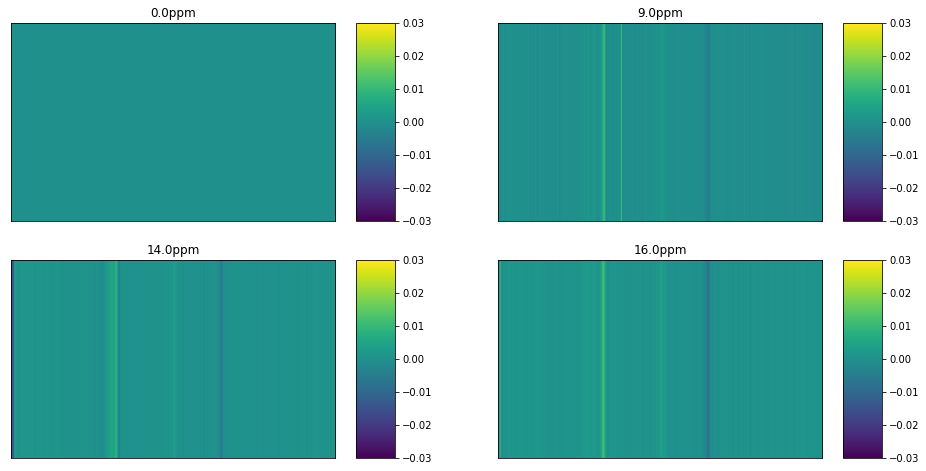

In [ ]:
layer_No = 2
filter_No = 1
fig,ax = plt.subplots(2,2,figsize = (16,8))
ax = ax.ravel()

for i in range (0,len(concentration)):
  # input_map = filter_vis[concentration[i]][layer_No][filter_No]
  input_map = [(a_i - b_i) for a_i, b_i in zip(autoencoder_filter_vis[concentration[i]][layer_No][filter_No], autoencoder_filter_vis[concentration[0]][layer_No][filter_No])]
  input_map = np.expand_dims(input_map, axis=0)
  pos = ax[i].imshow(input_map,cmap='viridis',aspect="auto",vmin=-0.03, vmax=0.03)
  ax[i].set_title(str(concentration[i]*max_concentration)+'ppm')
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  fig.colorbar(pos,aspect=5,ax=ax[i])

plt.show()

# Note for filter visualization:
Two methods were used for filter visualization. In the first method, all samples for each concentration were averaged at each layer and each filter. Then plooted.
In the second method, the average spectra of each concentration were passed into the network and then used for filter visulization.

### First method:

In [ ]:
#dic_avg = {conc.:{layer:(pixel,filter_No)} 

layers_dic_avg = {}
total_layer = 6
for conc in concentration_org:
  dummy_dic_0 = {}
  for i in range(0,total_layer):
    dummy_dic_0.update({i:np.mean(activation_dic[conc][i], axis=0)})
  layers_dic_avg.update({conc:dummy_dic_0})
  

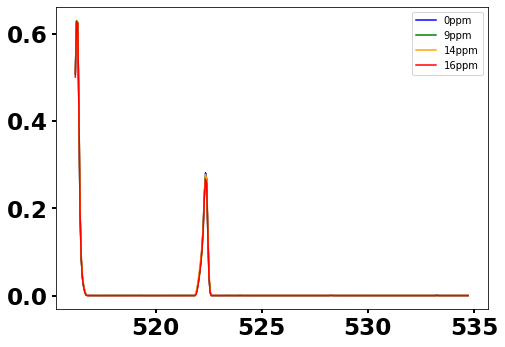

In [ ]:
color_dic = {0: 'blue', 1: 'green', 2: 'orange', 3:'red'}
label_dic = {0:'0ppm',1:'9ppm',2:'14ppm',3:'16ppm'}
concentration_dic = {0:0, 1:9, 2:14, 3:16}

layer_No = 1
selected_filter_No = 1

figure, ax = plt.subplots(figsize=(8,6))
figure.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.5, wspace=0.5)
#ax = ax.ravel()
for i in range(0, len(concentration_org)):
  ax.plot(activations_wavelength[layer_No][:,:,selected_filter_No][0],layers_dic_avg[concentration_dic[i]][layer_No][:,selected_filter_No],
            c =color_dic[i],label = label_dic[i])
  ax.legend()
  plt.setp(ax.get_xticklabels(), fontweight="bold")
  plt.setp(ax.get_yticklabels(), fontweight="bold")
  ax.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
#   ax.set_xlim(1265,1267)
#   ax.set_ylim(0.8,1.1)

### Second method:

In [ ]:
wavelength_input = wavelength.T.values.reshape(-1,wavelength.T.shape[1],1)
input_X_vis = X_mean.values.reshape(-1,X_mean.shape[1],1)

activations = activation_model.predict(input_X_vis) 
activations_wavelength = activation_model.predict(wavelength_input) 

In [ ]:
first_layer_activation = activations[0]
print('First layer shape',first_layer_activation.shape)

third_layer_activation = activations[2]
print('Third layer shape',third_layer_activation.shape)

wavelength_layer_activation = activations_wavelength[0]
print('Wavelegth First layer shape',wavelength_layer_activation.shape)

First layer shape (4, 1022, 5)
Third layer shape (4, 338, 3)
Wavelegth First layer shape (1, 1022, 5)


## CNN Filters Visualization

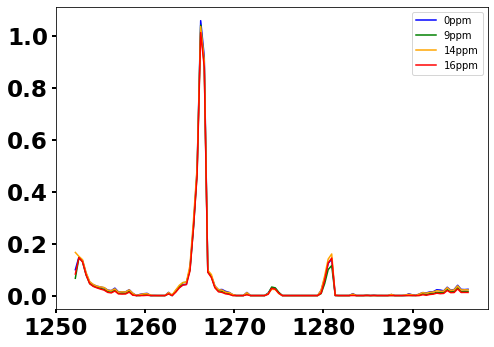

In [ ]:
layer_No = 5 #Starts from 0
filters_No = 3
selected_filter_No = 1

# fig, axes = plt.subplots(1,filters_No,figsize=(16,4))
# fig.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.5, wspace=0.5)

# for i in range (0,filters_No):
#   axes[i].plot(activations_wavelength[layer_No][:,:,i][0],activations[layer_No][:, :, i][0])
# plt.show()


color_dic = {0: 'blue', 1: 'green', 2: 'orange', 3:'red'}
label_dic = {0:'0ppm',1:'9ppm',2:'14ppm',3:'16ppm'}
figure, ax = plt.subplots(figsize=(8,6))
figure.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.5, wspace=0.5)

for i in range (0,4):
  plt.plot(activations_wavelength[layer_No][:,:,selected_filter_No][0],activations[layer_No][:, :, selected_filter_No][i],
           c =color_dic[i],label = label_dic[i] )
ax.legend()
plt.setp(ax.get_xticklabels(), fontweight="bold")
plt.setp(ax.get_yticklabels(), fontweight="bold")
ax.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
PATH = '/content/drive/My Drive/Data/Graphs/'
#plt.savefig(PATH+"L5_F1.png",format='png', dpi=1200)

## Dense Layers Visualization

In [ ]:
flatten_layer = activations[6]
dense_1 = activations[7]
dense_2 = activations[8]

In [ ]:
print('Dense_1 shape:',dense_1.shape)
print('Dense_2 shape:',dense_2.shape)
print('Wavelength shape for Dense_1:',activations_wavelength[7].shape)
print('Wavelength shape for Dense_2:',activations_wavelength[8].shape)

Dense_1 shape: (4, 100)
Dense_2 shape: (4, 100)
Wavelength shape for Dense_1: (1, 100)
Wavelength shape for Dense_2: (1, 100)


In [ ]:
color_dic = {0: 'blue', 1: 'green', 2: 'orange', 3:'red'}
label_dic = {0:'0ppm',1:'9ppm',2:'14ppm',3:'16ppm'}

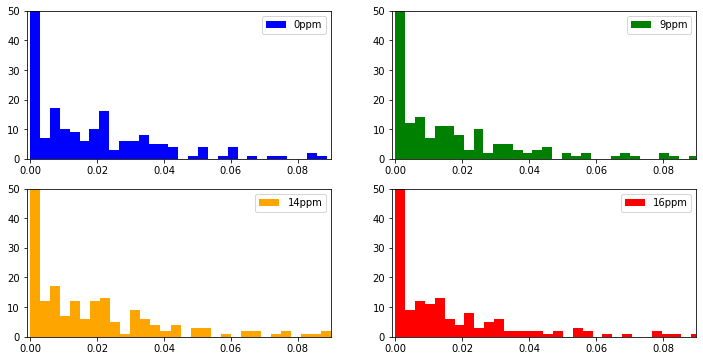

In [ ]:
count = [[],[],[],[]]
bins = [[],[],[],[]]
figure, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.ravel()
for i in range(0,4):
  count[i], bins[i], patches = ax[i].hist(flatten_layer[i], bins=600,label = label_dic[i],color=color_dic[i])
  ax[i].set_xlim(-0.001, 0.09)
  ax[i].set_ylim(0, 50)
  ax[i].legend()

## Obtaining the average distribution of spectra

In [ ]:
input_X_0 = conc_0_rnd.values.reshape(-1,conc_0_rnd.shape[1],1)
input_X_9 = conc_9_rnd.values.reshape(-1,conc_9_rnd.shape[1],1)
input_X_14 = conc_14_rnd.values.reshape(-1,conc_14_rnd.shape[1],1)
input_X_16 = conc_16_rnd.values.reshape(-1,conc_16_rnd.shape[1],1)

activations_0 = activation_model.predict(input_X_0)
activations_9 = activation_model.predict(input_X_9)
activations_14 = activation_model.predict(input_X_14)
activations_16 = activation_model.predict(input_X_16)

activation_dic = {0:activations_0,9:activations_9,14:activations_14,16:activations_16}

wavelength_input = wavelength.T.values.reshape(-1,wavelength.T.shape[1],1)
activations_wavelength = activation_model.predict(wavelength_input) 

In [ ]:
#count_dic = {ppm:{sample:count}}
#bin_dic = {ppm:{sample:bin}}
count_dic = {}
bin_dic = {}

layer_No = 6
bin_size = 600
for val in concentration_org:
  dummy_count = {}
  dummy_bin = {}
  for j in range(0,len(activation_dic[val][layer_No])):
    count,bin = np.histogram(activation_dic[val][layer_No][j],bin_size)
    dummy_count.update({j:count})
    dummy_bin.update({j:bin})
  count_dic.update({val:dummy_count})
  bin_dic.update({val:dummy_bin})

  
# bin_avg_dic = {ppm:{bin_no:avg}}
# count_avg_dic = {ppm:{bin_no:avg}}
bin_avg_dic = {}
count_avg_dic = {}

for val in concentration_org:
  dummy_1 = {}
  dummy_2 = {}
  for j in range(0,bin_size):
    bin_sum = 0
    count_sum = 0
    for i in range (0,len(bin_dic[val].keys())):
      bin_sum += bin_dic[val][i][j]
      count_sum += count_dic[val][i][j]    
    dummy_1.update({j:bin_sum/len(bin_dic[val].keys())})
    dummy_2.update({j:count_sum/len(count_dic[val].keys())})
  bin_avg_dic.update({val:dummy_1})
  count_avg_dic.update({val:dummy_2})
  
  
input_X_7 = conc_7_scaled.T.values.reshape(-1,conc_7_scaled.T.shape[1],1)
activations_7 = activation_model.predict(input_X_7) 
count_7ppm = {}
bin_7ppm = {}
for j in range(0,len(activations_7[6])):
  count,bin = np.histogram(activation_dic[val][layer_No][j],bin_size)
  count_7ppm.update({j:count})
  bin_7ppm.update({j:bin})
  
count_7ppm_avg = {}
bin_7ppm_avg = {}
for j in range(0,bin_size):
  bin_sum = 0
  count_sum = 0
  for i in range (0,len(bin_7ppm.keys())):
    bin_sum += bin_7ppm[i][j]
    count_sum += count_7ppm[i][j]    
  bin_7ppm_avg.update({j:bin_sum/len(bin_7ppm.keys())})
  count_7ppm_avg.update({j:count_sum/len(count_7ppm.keys())})

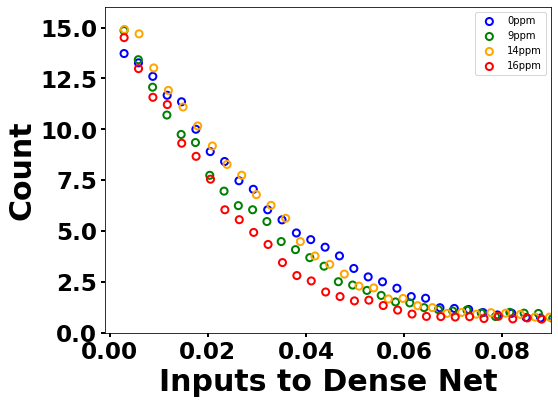

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
edge_dic = {0: 'blue', 9: 'green', 14: 'orange', 16:'red'}
label_val_dic = {0: '0ppm', 9: '9ppm', 14: '14ppm', 16:'16ppm'}

for val in bin_avg_dic.keys():
  ax.scatter([i for i in bin_avg_dic[val].values()],[i for i in count_avg_dic[val].values()],
             s=50,linewidth=2,facecolors='none', edgecolors=edge_dic[val],label = label_val_dic[val] )
  ax.set_xlim(-0.001, 0.09)
  ax.set_ylim(0, 16)
plt.setp(ax.get_xticklabels(), fontweight="bold")
plt.setp(ax.get_yticklabels(), fontweight="bold")
ax.set_xlabel('Inputs to Dense Net',fontsize=30,weight='bold')
ax.set_ylabel('Count',fontsize=30,weight='bold')
ax.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
ax.legend()
# PATH = '/content/drive/My Drive/Data/Graphs/'
# plt.savefig(PATH+"L5_F1.png",format='png', dpi=1200)
#ax.scatter([i for i in bin_7ppm_avg.values()],[i for i in count_7ppm_avg.values()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[ 1.54154015e+01  1.20000000e+01  1.40147502e-03 -4.55070072e-02]
[37.08142383 12.         -1.25628396 -0.25806524]
[ 1.71513971e+01  1.20000000e+01 -3.72755583e-04 -4.20557217e-02]
[42.96874548 12.         -1.03197844 -0.21687348]


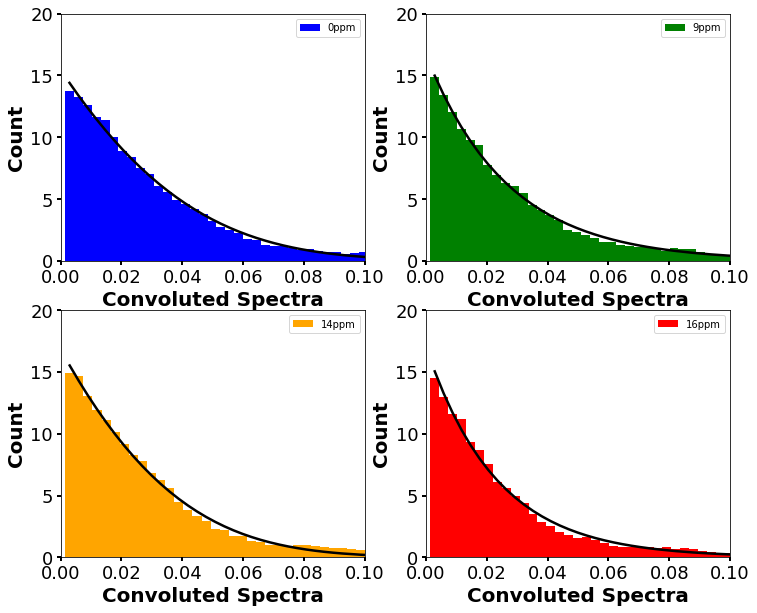

In [ ]:
from scipy.optimize import curve_fit
from scipy import special
import math 

def fit_function(x, A, B, mu, sigma):
  return A*np.exp(-A*x)+B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))

def fit_function_2(x, A, B, mu, sigma):
  return 0.5*A*np.exp(0.5*A*(2*mu+A*sigma**2-2*x)) * special.erfc((mu+A*(sigma)**2-x)/(sigma*math.sqrt(2)))


def full_Gauessian(x,y):
  dummy_x = -x
  return np.concatenate((np.sort(dummy_x), x)),np.concatenate((np.sort(y), y))


edge_dic = {0: 'blue', 9: 'green', 14: 'orange', 16:'red'}
dummy_dic = {0: 0, 9: 1, 14: 2, 16:3}
R_Squared = []

fig,ax = plt.subplots(2,2,figsize=(12,10))
figure.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 2.5, wspace=2.5)
ax = ax.ravel()
for val in bin_avg_dic.keys():
  x = np.array(list(bin_avg_dic[val].values()))[1:]
  y = np.array(list(count_avg_dic[val].values()))[1:]
  x_new,y_new = full_Gauessian(x,y)
  
  
  ### FIT TO GAUSSIAN FUNCTION
#   ax[dummy_dic[val]].bar(x_new,y_new,width=bin_avg_dic[val][1] - bin_avg_dic[val][0], color=edge_dic[val])
#   ax[dummy_dic[val]].set_xlim(-0.1,0.1)
#   ax[dummy_dic[val]].set_ylim(0,20)
#   popt, pcov = curve_fit(fit_function, xdata=x_new,ydata=y_new,p0=[0.05,12,3.0e-7,-2.0e-2])
#   print(popt)
#   ax[dummy_dic[val]].plot(x_new, fit_function(x_new, *popt), color='black', linewidth=2.5, label=r'Fitted function')
  
  ### FIT TO EXPONENTIALY MODIFIED GAUSSIAN
  ax[dummy_dic[val]].bar(x,y,width=bin_avg_dic[val][1] - bin_avg_dic[val][0], color=edge_dic[val],label=label_val_dic[val])
  ax[dummy_dic[val]].set_xlim(0,0.1)
  ax[dummy_dic[val]].set_ylim(0,20)
  popt, pcov = curve_fit(fit_function_2, xdata=x,ydata=y,p0=[0.05,12,3.0e-7,-2.0e-2],maxfev = 10000)
  print(popt)
  ax[dummy_dic[val]].plot(x, fit_function_2(x, *popt), color='black', linewidth=2.5)
  ax[dummy_dic[val]].set_xlabel('Convoluted Spectra',fontsize=20,weight='bold')
  ax[dummy_dic[val]].set_ylabel('Count',fontsize=20,weight='bold')
  ax[dummy_dic[val]].tick_params(which='both', length=4, width=2, labelsize=18,colors='black')
  ax[dummy_dic[val]].legend()
  
  residuals = y- fit_function_2(x, *popt)
  ss_res = np.sum(residuals**2)
  ss_tot = np.sum((y-np.mean(y))**2)
  r_squared = 1 - (ss_res / ss_tot)
  R_Squared.append(r_squared)

  
PATH = '/content/drive/My Drive/Data/Graphs/'
#plt.savefig(PATH+"Dense Inputs.png",format='png', dpi=1200)

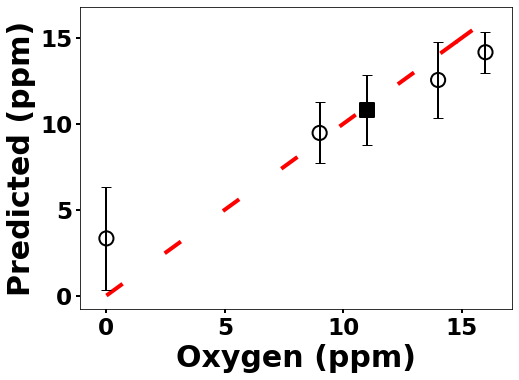

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
fig.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.6, wspace=0.6)


axes.plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes.scatter(concentration_org, average, s=200,linewidth=2,facecolors='none', edgecolors='black')
axes.set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes.set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes.errorbar(concentration_org, average, yerr=stdev,fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

axes.scatter(11, np.mean(Y_pred_loaded_11ppm*max_concentration),
             s=200,linewidth=2,facecolors='black', edgecolors='black',marker='s')
plotline, cap, barlinecols = axes.errorbar(11, np.mean(Y_pred_loaded_11ppm*max_concentration),
                                           yerr=np.std(Y_pred_loaded_11ppm*max_concentration),
                                           fmt='o', color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes.get_xticklabels(), fontweight="bold")
plt.setp(axes.get_yticklabels(), fontweight="bold")

PATH = '/content/drive/My Drive/Data/Graphs/'
#plt.savefig(PATH+"11ppm Prediction.png",format='png', dpi=1200)
#plt.show()

# Part II: LASSO:

In [ ]:
# X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=0.3,random_state = 1)
# X_train.shape

(649, 1024)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

alpha_minimize_Test= 8.177257525083613e-06
max_iter = 500000
Lasso_reg = linear_model.Lasso(alpha_minimize_Test,max_iter)
Lasso_reg.fit(X_train, Y_train)
y_pred_Lasso_reg=Lasso_reg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43444696555194806, tolerance: 0.009560849624422186
  positive)


R2= 0.9736203734427757


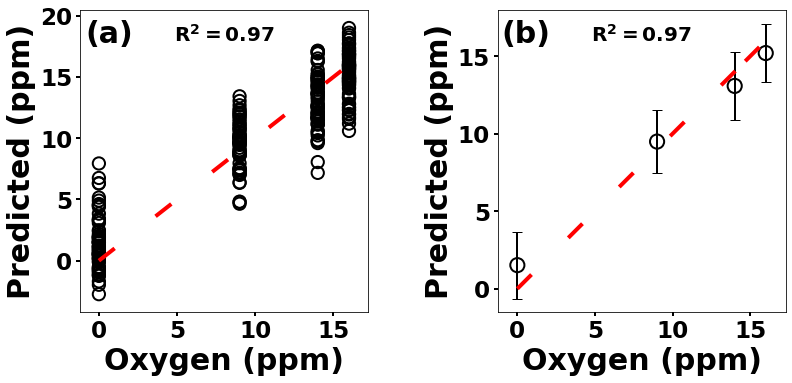

In [ ]:
LASSO_test_result_dic = {0:[],9:[],14:[],16:[]}
LASSO_predic_conc = [[],[],[],[]]

i = 0
for val in Y_test['O (ppm)']:
  LASSO_test_result_dic[val*max_concentration].append(y_pred_Lasso_reg[i]*max_concentration)
  i += 1
  
LASSO_avg_dic = {}
for key in LASSO_test_result_dic:
  dummy_list = []
  for i in range (0,len(LASSO_test_result_dic[key])):
    dummy_list.append(LASSO_test_result_dic[key][i])
  LASSO_avg_dic.update({key:[statistics.mean(dummy_list),statistics.stdev(dummy_list)]})
  
  
LASSO_average = []
LASSO_stdev = []
for val in LASSO_avg_dic.keys():
  LASSO_average.append(LASSO_avg_dic[val][0])
  LASSO_stdev.append(LASSO_avg_dic[val][1])

fig, axes = plt.subplots(1,2,figsize=(14,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.2,hspace = 0.45, wspace=0.45)
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')

#axes = axes.ravel()

# axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
#           linestyle='--',dashes=(5, 13))
# axes[0].scatter(Y_test*max_concentration, y_pred_Lasso_reg*max_concentration, s=150,linewidth=2,
#             facecolors='none', edgecolors='black')

# axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
# axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
# axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')

# plt.setp(axes[0].get_xticklabels(), fontweight="bold")
# plt.setp(axes[0].get_yticklabels(), fontweight="bold")

axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[0].scatter(Y_test*max_concentration, y_pred_Lasso_reg*max_concentration, s=150,linewidth=2,
            facecolors='none', edgecolors='black')

axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')

plt.setp(axes[0].get_xticklabels(), fontweight="bold")
plt.setp(axes[0].get_yticklabels(), fontweight="bold")


# axes[0].boxplot(test_result_dic.values(),positions=concentration_org,showmeans=True,flierprops=flierprops)
# axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
#           linestyle='--',dashes=(5, 13))
# axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
# axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
# plt.setp(axes[0].get_xticklabels(), fontweight="bold")
# plt.setp(axes[0].get_yticklabels(), fontweight="bold")
# axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')


# axes[1].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
#           linestyle='--',dashes=(5, 13))
# axes[1].scatter(concentration_org, LASSO_average, s=200,linewidth=2,facecolors='none', edgecolors='black')

# axes[1].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
# axes[1].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
# axes[1].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
# plotline, cap, barlinecols = axes[1].errorbar(concentration_org, LASSO_average, yerr=LASSO_stdev,fmt='o', 
#                                            color='none',ecolor='black', elinewidth=2,capsize=5)

# plt.setp(axes[1].get_xticklabels(), fontweight="bold")
# plt.setp(axes[1].get_yticklabels(), fontweight="bold")


axes[1].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[1].scatter(concentration_org, LASSO_average, s=200,linewidth=2,facecolors='none', edgecolors='black')

axes[1].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[1].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[1].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes[1].errorbar(concentration_org, LASSO_average, yerr=LASSO_stdev,fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes[1].get_xticklabels(), fontweight="bold")
plt.setp(axes[1].get_yticklabels(), fontweight="bold")

print('R2=',r2_score(concentration_org, LASSO_average))
text(0.5, 0.92,'$\mathbf{R^2=0.97}$',fontweight="bold",fontsize=20, ha='center', va='center', transform=axes[0].transAxes)
text(0.1, 0.92,'(a)',fontweight="bold",fontsize=30, ha='center', va='center', transform=axes[0].transAxes)
text(0.5, 0.92,'$\mathbf{R^2=0.97}$',fontweight="bold",fontsize=20, ha='center', va='center', transform=axes[1].transAxes)
text(0.1, 0.92,'(b)',fontweight="bold",fontsize=30, ha='center', va='center', transform=axes[1].transAxes)


PATH = '/content/drive/My Drive/Data/Graphs/Final/LASSO/'
# plt.savefig(PATH+"Prediction_LASSO_avg_2.png",format='png', dpi=1200)
#plt.show()

### LOD LASSO:
LOD is not determined. This needs further investigation. It seems that LASSO is capable of predicting the seen classes. However, it is not very predictive for unseen classes. In other words, it learns pretty well the known cases however in term of interpratation it faces issues.

In [ ]:
from numpy import linalg as LA

mean_scaled_dic = {0:conc_0_mean_scaled,1:conc_9_mean_scaled,2:conc_14_mean_scaled,3:conc_16_mean_scaled,}
noise_list = []
for i in mean_scaled_dic.keys():
  noise_list.append(((mean_scaled_dic[i][549:586])**2).mean()**(0.5))

noise = np.array(noise_list).mean()

print('LOD=',3*noise*LA.norm(Lasso_reg.coef_))


LOD= 0.6801689671841455


In [ ]:
X_test_11ppm = conc_11_scaled.T
y_pred_Lasso_reg_11ppm=Lasso_reg.predict(X_test_11ppm)

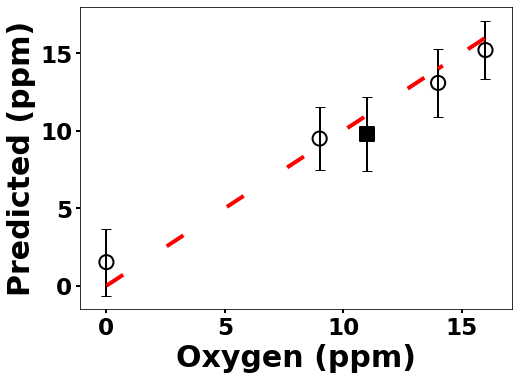

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
fig.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.6, wspace=0.6)


axes.plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes.scatter(concentration_org, LASSO_average, s=200,linewidth=2,facecolors='none', edgecolors='black')
axes.set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes.set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes.errorbar(concentration_org, LASSO_average, yerr=LASSO_stdev,fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

axes.scatter(11, np.mean(y_pred_Lasso_reg_11ppm*max_concentration),
             s=200,linewidth=2,facecolors='black', edgecolors='black',marker='s')
plotline, cap, barlinecols = axes.errorbar(11, np.mean(y_pred_Lasso_reg_11ppm*max_concentration),
                                           yerr=np.std(y_pred_Lasso_reg_11ppm*max_concentration),
                                           fmt='o', color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes.get_xticklabels(), fontweight="bold")
plt.setp(axes.get_yticklabels(), fontweight="bold")

PATH = '/content/drive/My Drive/Data/Graphs/LASSO/'
#plt.savefig(PATH+"11ppm Prediction_LASSO.png",format='png', dpi=1200)
#plt.show()

No. coefficients =  173
LOD =  55.65003134197137 ppm


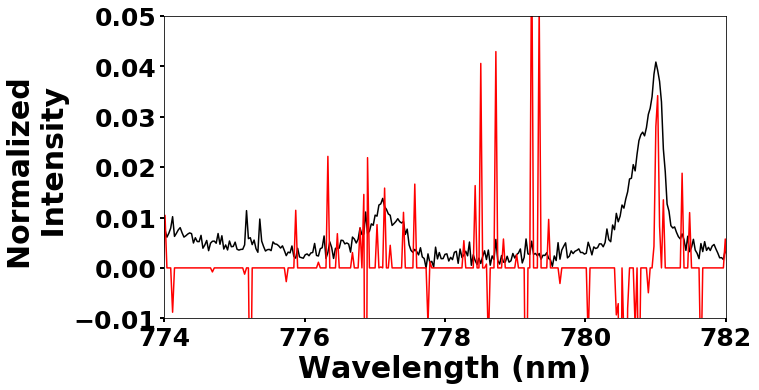

In [ ]:
coeff_LASSO = Lasso_reg.coef_

norm_coef = []
lasso_wavelength = []
for i in range(0,len(coeff_LASSO)):
    if coeff_LASSO[i]!=0:
      if coeff_LASSO[i]>0:
        norm_coef.append(1)
        lasso_wavelength.append(wavelength.T[i].values)
      else:
        norm_coef.append(-1)
    else:
        norm_coef.append(0)
        
print('No. coefficients = ',np.count_nonzero(coeff_LASSO))
#print('Chosen wavelength = ',[np.round(k.item(),decimals=3) for k in lasso_wavelength])
        
noise_list = []
for i in range (0,X.shape[0]):
    noise_list.append(((X.iloc[i,965:995])**2).mean()**(0.5))
noise = np.array(noise_list).mean()

LOD_LASSO = 3*noise*max_concentration*np.linalg.norm(coeff_LASSO)
print('LOD = ',LOD_LASSO, 'ppm')

LASSO_wavelength = [0.1*float(i)/max(coeff_LASSO) for i in coeff_LASSO]

fig, ax = plt.subplots(figsize=(12,6))

plt.plot(wavelength, conc_0_mean_scaled,  color='black',linewidth=1.5)
plt.plot(wavelength, LASSO_wavelength,  color='red',linewidth=1.5)
plt.xlabel('Wavelength (nm)',fontsize=30,weight='bold')
plt.ylabel('Normalized \n Intensity',fontsize=30,weight='bold')
plt.xlim(774,782)
plt.ylim(-0.01,0.05)
plt.tick_params(which='both', length=4, width=2, labelsize=25,colors='black')
plt.setp(ax.get_xticklabels(), fontweight="bold")
plt.setp(ax.get_yticklabels(), fontweight="bold")
#plt.xlim(200,800)
fig.subplots_adjust(left = 0.25,top=0.9, bottom=0.2,hspace = 0.5, wspace=0.5)
PATH = '/content/drive/My Drive/Data/Graphs/LASSO/'
#plt.savefig(PATH+'spectrum_LASSO.png', format='png', dpi=1200)

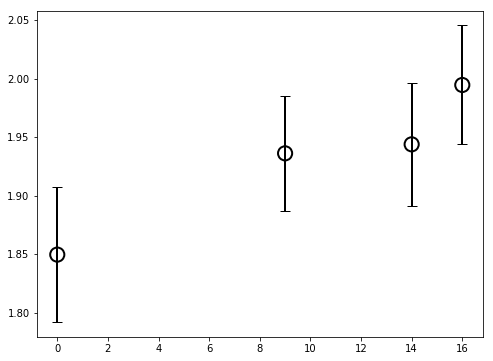

In [ ]:
rnd_spectra_dic = {0:conc_0_rnd, 1:conc_9_rnd, 2:conc_14_rnd, 3:conc_16_rnd}
dot_prod_dic = {}
for i in range (0,4):
  dummy_list = []
  for j in range (rnd_spectra_dic[i].shape[0]):
    dummy_list.append(np.dot(rnd_spectra_dic[i].iloc[j,:],norm_coef))
  dot_prod_dic.update({i:dummy_list})
  
fig,ax = plt.subplots(figsize=(8,6))  
ax.scatter(concentration_org,[statistics.mean(dot_prod_dic[i])for i in range(0,4)],s=200,linewidth=2,facecolors='none', edgecolors='black' )
plotline, cap, barlinecols = ax.errorbar(concentration_org, [statistics.mean(dot_prod_dic[i])for i in range(0,4)],
                                           yerr=[statistics.stdev(dot_prod_dic[i])for i in range(0,4)],
                                           fmt='o', color='none',ecolor='black', elinewidth=2,capsize=5)

# Part III: Linear Regression Based on Oxygen Peak

In [ ]:
PATH = '/content/drive/My Drive/Data/'
bad_cal = pd.read_csv(PATH+'03-10-16.csv', delimiter=',', header=None)

In [ ]:
from sklearn.linear_model import LinearRegression

X_train_LR = X_train[516].copy()
Y_train_LR = Y_train['O (ppm)'].copy()
X_test_LR = X_test[516].copy()


LR_model = LinearRegression()
LR_model.fit(np.array(X_train_LR).reshape(-1, 1), np.array(Y_train_LR))
LR_R_sq = LR_model.score(np.array(X_train_LR).reshape(-1, 1), Y_train_LR)
print('R2 for Linear Regression:',LR_R_sq)
LR_predictions = LR_model.predict(np.array(X_test_LR).reshape(-1,1))

R2 for Linear Regression: 0.0013801080214382864


In [ ]:
# , Y_test*max_concentration
# Y_test*max_concentration, LR_predictions*max_concentration
fig_2_df = pd.DataFrame(data=Y_test*max_concentration)
fig_2_df['LR']=LR_predictions*max_concentration
PATH = '/content/drive/My Drive/Data/for_dibs/'
fig_2_df.to_csv(PATH+'fig_2.csv')

R2= 0.007658478781746081


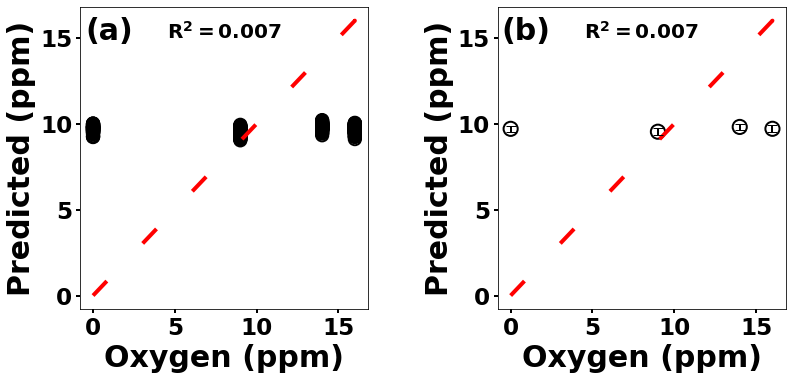

In [ ]:
LR_test_result_dic = {0:[],9:[],14:[],16:[]}
LR_predic_conc = [[],[],[],[]]

i = 0
for val in Y_test['O (ppm)']:
  LR_test_result_dic[val*max_concentration].append(LR_predictions[i]*max_concentration)
  i += 1
  
LR_avg_dic = {}
for key in LR_test_result_dic:
  dummy_list = []
  for i in range (0,len(LR_test_result_dic[key])):
    dummy_list.append(LR_test_result_dic[key][i])
  LR_avg_dic.update({key:[statistics.mean(dummy_list),statistics.stdev(dummy_list)]})
  
  
LR_average = []
LR_stdev = []
for val in LR_avg_dic.keys():
  LR_average.append(LR_avg_dic[val][0])
  LR_stdev.append(LR_avg_dic[val][1])

fig, axes = plt.subplots(1,2,figsize=(14,6))
fig.subplots_adjust(left = 0.2,top=0.9, bottom=0.2,hspace = 0.45, wspace=0.45)
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')

# axes = axes.ravel()

# axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
#           linestyle='--',dashes=(5, 13))
# axes[0].scatter(Y_test*max_concentration, LR_predictions*max_concentration, s=150,linewidth=2,
#             facecolors='none', edgecolors='black')

# axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
# axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
# axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')

# plt.setp(axes[0].get_xticklabels(), fontweight="bold")
# plt.setp(axes[0].get_yticklabels(), fontweight="bold")


axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[0].scatter(Y_test*max_concentration, LR_predictions*max_concentration, s=150,linewidth=2,
            facecolors='none', edgecolors='black')

axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')

plt.setp(axes[0].get_xticklabels(), fontweight="bold")
plt.setp(axes[0].get_yticklabels(), fontweight="bold")


# axes[0].boxplot(test_result_dic.values(),positions=concentration_org,showmeans=True,flierprops=flierprops)
# axes[0].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
#           linestyle='--',dashes=(5, 13))
# axes[0].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
# axes[0].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
# plt.setp(axes[0].get_xticklabels(), fontweight="bold")
# plt.setp(axes[0].get_yticklabels(), fontweight="bold")
# axes[0].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')


# axes[1].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
#           linestyle='--',dashes=(5, 13))
# axes[1].scatter(concentration_org, LR_average, s=200,linewidth=2,facecolors='none', edgecolors='black')

# axes[1].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
# axes[1].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
# axes[1].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
# plotline, cap, barlinecols = axes[1].errorbar(concentration_org, LR_average, yerr=LR_stdev,fmt='o', 
#                                            color='none',ecolor='black', elinewidth=2,capsize=5)

# plt.setp(axes[1].get_xticklabels(), fontweight="bold")
# plt.setp(axes[1].get_yticklabels(), fontweight="bold")


axes[1].plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes[1].scatter(concentration_org, LR_average, s=200,linewidth=2,facecolors='none', edgecolors='black')

axes[1].set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes[1].set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes[1].tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes[1].errorbar(concentration_org, LR_average, yerr=LR_stdev,fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes[1].get_xticklabels(), fontweight="bold")
plt.setp(axes[1].get_yticklabels(), fontweight="bold")

print('R2=',r2_score(concentration_org, LR_average))
text(0.5, 0.92,'$\mathbf{R^2=0.007}$',fontweight="bold",fontsize=20, ha='center', va='center', transform=axes[0].transAxes)
text(0.1, 0.92,'(a)',fontweight="bold",fontsize=30, ha='center', va='center', transform=axes[0].transAxes)
text(0.5, 0.92,'$\mathbf{R^2=0.007}$',fontweight="bold",fontsize=20, ha='center', va='center', transform=axes[1].transAxes)
text(0.1, 0.92,'(b)',fontweight="bold",fontsize=30, ha='center', va='center', transform=axes[1].transAxes)
PATH = '/content/drive/My Drive/Data/Graphs/Final/LR/'
# plt.savefig(PATH+"Prediction_LR_avg_2.png",format='png', dpi=1200)
#plt.show()

In [ ]:
LR_predictions_11ppm = LR_model.predict(np.array(X_test_11ppm).reshape(-1,1))

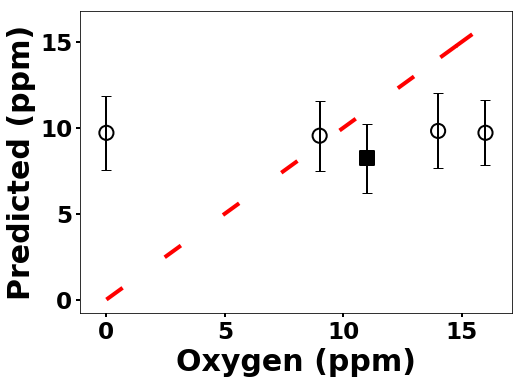

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
fig.subplots_adjust(left = 0.15,top=0.9, bottom=0.2,hspace = 0.6, wspace=0.6)


axes.plot(Y_test*max_concentration, Y_test*max_concentration,  color='red',linewidth=4,
          linestyle='--',dashes=(5, 13))
axes.scatter(concentration_org, LR_average, s=200,linewidth=2,facecolors='none', edgecolors='black')
axes.set_xlabel('Oxygen (ppm)',fontsize=30,weight='bold')
axes.set_ylabel('Predicted (ppm)',fontsize=30,weight='bold')
axes.tick_params(which='both', length=4, width=2, labelsize=23,colors='black')
plotline, cap, barlinecols = axes.errorbar(concentration_org, LR_average, yerr=LASSO_stdev,fmt='o', 
                                           color='none',ecolor='black', elinewidth=2,capsize=5)

axes.scatter(11, np.mean(LR_predictions_11ppm*max_concentration),
             s=200,linewidth=2,facecolors='black', edgecolors='black',marker='s')
plotline, cap, barlinecols = axes.errorbar(11, np.mean(LR_predictions_11ppm*max_concentration),
                                           yerr=2,
                                           fmt='o', color='none',ecolor='black', elinewidth=2,capsize=5)

plt.setp(axes.get_xticklabels(), fontweight="bold")
plt.setp(axes.get_yticklabels(), fontweight="bold")

PATH = '/content/drive/My Drive/Data/Graphs/LR/'
plt.savefig(PATH+"11ppm Prediction_LR.png",format='png', dpi=1200)
#plt.show()

In [ ]:
conc_overal = concentration_org[:]
conc_overal[2:2] = [11]

CNN_average_overall = average[:]
CNN_average_overall[2:2] = [np.mean(Y_pred_loaded_11ppm*max_concentration)]

LASSO_average_overall = LASSO_average[:]
LASSO_average_overall[2:2] = [np.mean(y_pred_Lasso_reg_11ppm*max_concentration)]

LR_average_overall = LR_average[:]
LR_average_overall[2:2] = [np.mean(LR_predictions_11ppm*max_concentration)]

In [ ]:
from sklearn.metrics import mean_squared_error 

Y_true_11pm = [11]*len(LR_predictions_11ppm*max_concentration)
a_test = np.array(LR_predictions_11ppm*max_concentration)
a_test.tolist()
mean_squared_error(Y_true_11pm,a_test) 

106.09038478428162

# Metrics Comparison for Various Models:

In [ ]:
from sklearn.metrics import r2_score

R2_CNN = r2_score(conc_overal, CNN_average_overall)
R2_LASSO = r2_score(conc_overal, LASSO_average_overall) 
R2_LR = r2_score(conc_overal, LR_average_overall) 
print('R2 CNN:',R2_CNN)
print('R2 LASSO:',R2_LASSO)
print('R2 LR:',R2_LR)

print('----------')

MSE_dic = {'Linear Regression':mean_squared_error(conc_overal,LR_average_overall),
           'LASSO':mean_squared_error(conc_overal,LASSO_average_overall),
           'CNN':mean_squared_error(conc_overal,CNN_average_overall)}
for keys in MSE_dic.keys():
  print(keys,' MSE:',MSE_dic[keys]) 
  

R2 CNN: 0.8908657251969013
R2 LASSO: 0.9645516220523181
R2 LR: -0.0342821116281109
----------
Linear Regression  MSE: 31.85588903814582
LASSO  MSE: 1.0918100407886009
CNN  MSE: 3.36133566393544
